In [2]:
test_data.equals(test_data_temp) and train_data.equals(train_data_temp) and tuning_data.equals(tune_data_temp)

NameError: name 'test_data' is not defined

In [3]:
from autogluon.tabular import TabularDataset, TabularPredictor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Table of contents 

**Exploratory data analysis**
To avoid the deduction, you should do at least four or more items of the following list:

- Search domain knowledge 
- Understand how the data was generated
- Explore individual features
- Explore pairs and groups of features
- Check if the data is intuitive
- Clean up features

**Feature engineering**
To avoid the deduction, you should try one or more feature engineering techniques (i.e., feature selection and/or feature extraction) in the long notebook.

**Number of predictors**
To avoid the deduction, you should try two or more types of predictors in the long notebook (e.g., XGBoost and Random Forest). It is allowed to use only one type of predictor in the short notebook and Kaggle predictions.

**Model interpretation**
To avoid the deduction, you should use one or more model interpretation techniques (e.g., PDP, feature importance, LIME) in the long notebook.

# Search domain knowledge, Understand how the data was generated

This is a list of the sources we found to understand the domain of solar energy forecasting. 

1-s2.0-S1364032121010364-main.pdf
https://www.researchgate.net/publication/359439616_A_review_of_solar_forecasting_its_dependence_on_atmospheric_sciences_and_implications_for_grid_integration_Towards_carbon_neutrality

Benchmarks-for-solar-radiation-time-series-forecasting_2022_Renewable-Energy.pdf
https://hal.science/hal-03995928/document


Ensemble-solar-forecasting-and-post-processing-using-d_2022_Renewable-and-Su.pdf
https://www.researchgate.net/publication/356726325_Ensemble_solar_forecasting_and_post-processing_using_dropout_neural_network_and_information_from_neighboring_satellite_pixels


Integrated-life-cycle-optimisation-and-supply-si_2022_Renewable-and-Sustaina.pdf
https://uwe-repository.worktribe.com/output/8219224/integrated-life-cycle-optimisation-and-supply-side-management-for-building-retrofitting

On-post-processing-day-ahead-NWP-forecasts-using-Kalman-filt_2019_Solar-Ener.pdf
https://www.researchgate.net/publication/331370405_On_post-processing_day-ahead_NWP_forecasts_using_Kalman_filtering

Sub-minute-probabilistic-solar-forecasting-for-_2022_Renewable-and-Sustainab.pdf
https://www.researchgate.net/publication/355533775_Sub-minute_probabilistic_solar_forecasting_for_real-time_stochastic_simulations

Verification-of-deterministic-solar-forecasts_2020_Solar-Energy.pdf
https://personal.utdallas.edu/~jiezhang/Journals/Zhang_2020_SE_deterministic_verification.pdf

## Notes for individual features after doing research

We read up on each feature on this website: https://www.meteomatics.com/en/api/available-parameters/alphabetic-list/

After reading about the individual features in the website that is linked to on blackboard, we ended up discarding quite a few features that we thought would not help that much in prediction the power production. These are some quick notes that we made after reading about the features. We got quite a good score by using the selection of these features at about 146. However, in the end, we found out that the best solution was to use almost all the features.

### Thoughts about the features after reasearch
| Feature | Notes |
| --- | --- |
| t_1000hPa:K, direct_rad | Maybe we can use these together with wind speed inverse or something, to model of efficiency of the solar panel, because higher wind will move air around the panels faster. |
| wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms | can be dropped, since we have wind_speed_10m:ms |
| snow and precipitation | After reasearching how snow affects solar panels, we found that the solar panels are often at an angle and the heat produced by the panels make the snow slide off the panels really quickly after ending up on the panel. I think we only should keep snow_depth:cm (for reflection) and fresh_snow_1h:cm.  snow_density:kgm3 has a ton of missing values. Maybe we should set those to zero. Maybe it is so that when the snow density is above a certain value it covers the solar panels. |
| snow_drift | Always 0 for loc A, so we can drop it |
| pressure | This does not seem to have any effect on pv_production. Drop. |
| radiation | use only last hour, not effect (W) create global_rad_1h:J, which is the sum of direct_rad_1h:J and diffuse_rad_1h:J drop clear_sky_energy_1h:J and clear_sky_rad:W |
| clear_sky_energy_1h:J and clear_sky_rad:W | drop them, as direct and diffuse radiation should be sufficient |
| cloud height | drop them |
| dew_or_rime:idx | Change this to one variable for is_dew and one variable for is_rime |
| is_in_shadow:idx and is_day:idx | drop them, we have better variables for this, e.g. effective_cloud_cover:p (dont use total_cloud_cover:p) |


# Config

We chose to centralize all config in the top here to make it easy to run different variations of the pipeline. Some of these configs are not used in the final solution, but we keep them here for showing what we tried.

In [ ]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = None
presets = "experimental_zeroshot_hpo_hybrid"#'best_quality'

num_seeds = 3

do_drop_ds = True
# hour, dayofweek, dayofmonth, month, year
use_dt_attrs = []#["hour", "year"]
use_estimated_diff_attr = False
use_is_estimated_attr = True

drop_night_outliers = True
drop_null_outliers = False

# to_drop = ["snow_drift:idx", "snow_density:kgm3", "wind_speed_w_1000hPa:ms", "dew_or_rime:idx", "prob_rime:p", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms", "snow_melt_10min:mm", "rain_water:kgm2", "dew_point_2m:K", "precip_5min:mm", "absolute_humidity_2m:gm3", "air_density_2m:kgm3"]#, "msl_pressure:hPa", "pressure_50m:hPa",  "pressure_100m:hPa"]
to_drop = ["wind_speed_w_1000hPa:ms", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms"]

excluded_model_types = ['CAT', 'XGB', 'RF']

use_groups = False
n_groups = 8

# auto_stack = True
num_stack_levels = 0
num_bag_folds = 6# 8
num_bag_sets = 2#20

use_tune_data = True
use_test_data = False
#tune_and_test_length = 0.5 # 3 months from end
# holdout_frac = None
use_bag_holdout = True # Enable this if there is a large gap between score_val and score_test in stack models. 

sample_weight = None#'sample_weight' #None
weight_evaluation = False#
sample_weight_estimated = 1
sample_weight_may_july = 1

run_analysis = False

shift_predictions_by_average_of_negatives_then_clip = False
clip_predictions = True
shift_predictions = False

# Preprocessing / Feature Engineering

In this code we shift some of the columns by 1 hour. This was because the pv_measurment at time 15:00 is the power produced from 15:00-15:59. While we thought that e.g. direct_rad_1h:J was the radiation from 14:00-14:59. However, in our testing we found that despite of this, it resulted in slightly worse scores. The short notebook 1 uses the shifted columns, while the short notebook 2 does not.

In [25]:
class FeatureEngineer:
    def __init__(self):
        self.columns_to_shift = [
            'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
            'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
            'fresh_snow_3h:cm', 'fresh_snow_6h:cm'
        ]

    # set X setter
    def set_X(self, X):
        self.X = X

    def shift_columns_by_one_hour(self):
        X_shifted = self.X[self.X.index.minute == 0][self.columns_to_shift].copy()
        one_hour = pd.Timedelta('1 hour')
        shifted_indices = X_shifted.index + one_hour
        index_set = set(self.X.index)
        X_shifted.loc[shifted_indices.isin(index_set)] = self.X.loc[shifted_indices[shifted_indices.isin(index_set)]][self.columns_to_shift]
        self.X_shifted = X_shifted

    def handle_edge_cases(self):
        self.X_shifted.iloc[-1] = self.X_shifted.iloc[-2]

    def count_shifted_rows(self):
        shifted_indices = self.X_shifted.index + pd.Timedelta('1 hour')
        index_set = set(self.X_shifted.index)
        self.count1 = len(shifted_indices[shifted_indices.isin(index_set)])
        self.count2 = len(self.X_shifted) - self.count1

    def resample_to_hourly(self):
        self.X = self.X.resample('H').mean()

    def integrate_shifted_data(self):
        self.X[self.columns_to_shift] = self.X_shifted[self.columns_to_shift]
        if 'date_calc' in self.X.columns:
            self.X['date_calc'] = self.X[self.X.index.minute == 0]['date_calc']

    def process(self, X):
        self.X = X
        self.shift_columns_by_one_hour()
        self.handle_edge_cases()
        self.count_shifted_rows()
        self.resample_to_hourly()
        self.integrate_shifted_data()

        return self.X


def convert_to_datetime_and_set_index(X, date_column='date_forecast', new_index_name='ds'):
    # Convert the date column to a datetime object and create a new column
    X[new_index_name] = pd.to_datetime(X[date_column])

    # Remove the original date column from the DataFrame
    X.drop(columns=[date_column], inplace=True, errors='ignore')

    # Sort the DataFrame based on the new datetime column
    X.sort_values(by=new_index_name, inplace=True)

    # Set the new datetime column as the index of the DataFrame
    X.set_index(new_index_name, inplace=True)

    return X


def preprocess(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = convert_to_datetime_and_set_index(X_train_observed)
    X_train_estimated = convert_to_datetime_and_set_index(X_train_estimated)
    X_test = convert_to_datetime_and_set_index(X_test)
    y_train = convert_to_datetime_and_set_index(y_train, date_column='time', new_index_name='ds')


    return X_train_observed, X_train_estimated, X_test, y_train

def feature_engineering(X_train_observed, X_train_estimated, X_test, y_train):
    feature_engineer = FeatureEngineer()

    X_train_observed = feature_engineer.process(X_train_observed)
    X_train_estimated = feature_engineer.process(X_train_estimated)
    X_test = feature_engineer.process(X_test)

    return X_train_observed, X_train_estimated, X_test, y_train

def handle_estimated_diff(X_train_observed, X_train_estimated, X_test):
    if use_estimated_diff_attr:
        X_train_observed["estimated_diff_hours"] = 0
        X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
        X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

        X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
        X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')

    return X_train_observed, X_train_estimated, X_test

def handle_is_estimated(X_train_observed, X_train_estimated, X_test):
    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1
    return X_train_observed, X_train_estimated, X_test

def drop_columns(X_train_estimated, X_test, columns_to_drop=['date_calc']):
    X_train_estimated.drop(columns=columns_to_drop, inplace=True)
    X_test.drop(columns=columns_to_drop, inplace=True)
    return X_train_estimated, X_test

def rename_target(y_train):
    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    return y_train

def merge_data(X_train_observed, X_train_estimated, y_train):
    X_train = pd.concat([X_train_observed, X_train_estimated])
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)
    return X_train

def set_location(X_train, X_test, location):
    X_train["location"] = location
    X_test["location"] = location
    return X_train, X_test

def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # Convert to datetime and feature engineering
    X_train_observed, X_train_estimated, X_test, y_train = preprocess(X_train_observed, X_train_estimated, X_test, y_train)
    X_train_observed, X_train_estimated, X_test, y_train = feature_engineering(X_train_observed, X_train_estimated, X_test, y_train)

    # Handle estimated differences
    X_train_observed, X_train_estimated, X_test = handle_estimated_diff(X_train_observed, X_train_estimated, X_test)

    # Handle is_estimated attribute
    X_train_observed, X_train_estimated, X_test = handle_is_estimated(X_train_observed, X_train_estimated, X_test)

    # Drop date_calc column
    X_train_estimated, X_test = drop_columns(X_train_estimated, X_test)

    # Rename target
    y_train = rename_target(y_train)

    # Merge data
    X_train = merge_data(X_train_observed, X_train_estimated, y_train)

    # Set location
    X_train, X_test = set_location(X_train, X_test, location)

    return X_train, X_test


def load_and_process():
    # Define locations
    X_trains = []
    X_tests = []
    # Loop through locations
    for loc in locations:
        print(f"Processing location {loc}...")
        # Read target training data
        y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
        X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
        X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')
        X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

        X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

        X_trains.append(X_train)
        X_tests.append(X_test)

    # Concatenate all data and save to csv
    X_train = pd.concat(X_trains)
    X_test = pd.concat(X_tests)

    return X_train, X_test

locations = ['A', 'B', 'C']
X_train, X_test = load_and_process()
X_train.columns

Processing location A...
Processing location B...
Processing location C...


Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

# Removing anomalies

### Pair and groups of features

We look at the relationship between radiation, sul elevation and pv_measurment and found some outliers/not intuitive values. We decided to remove these values.

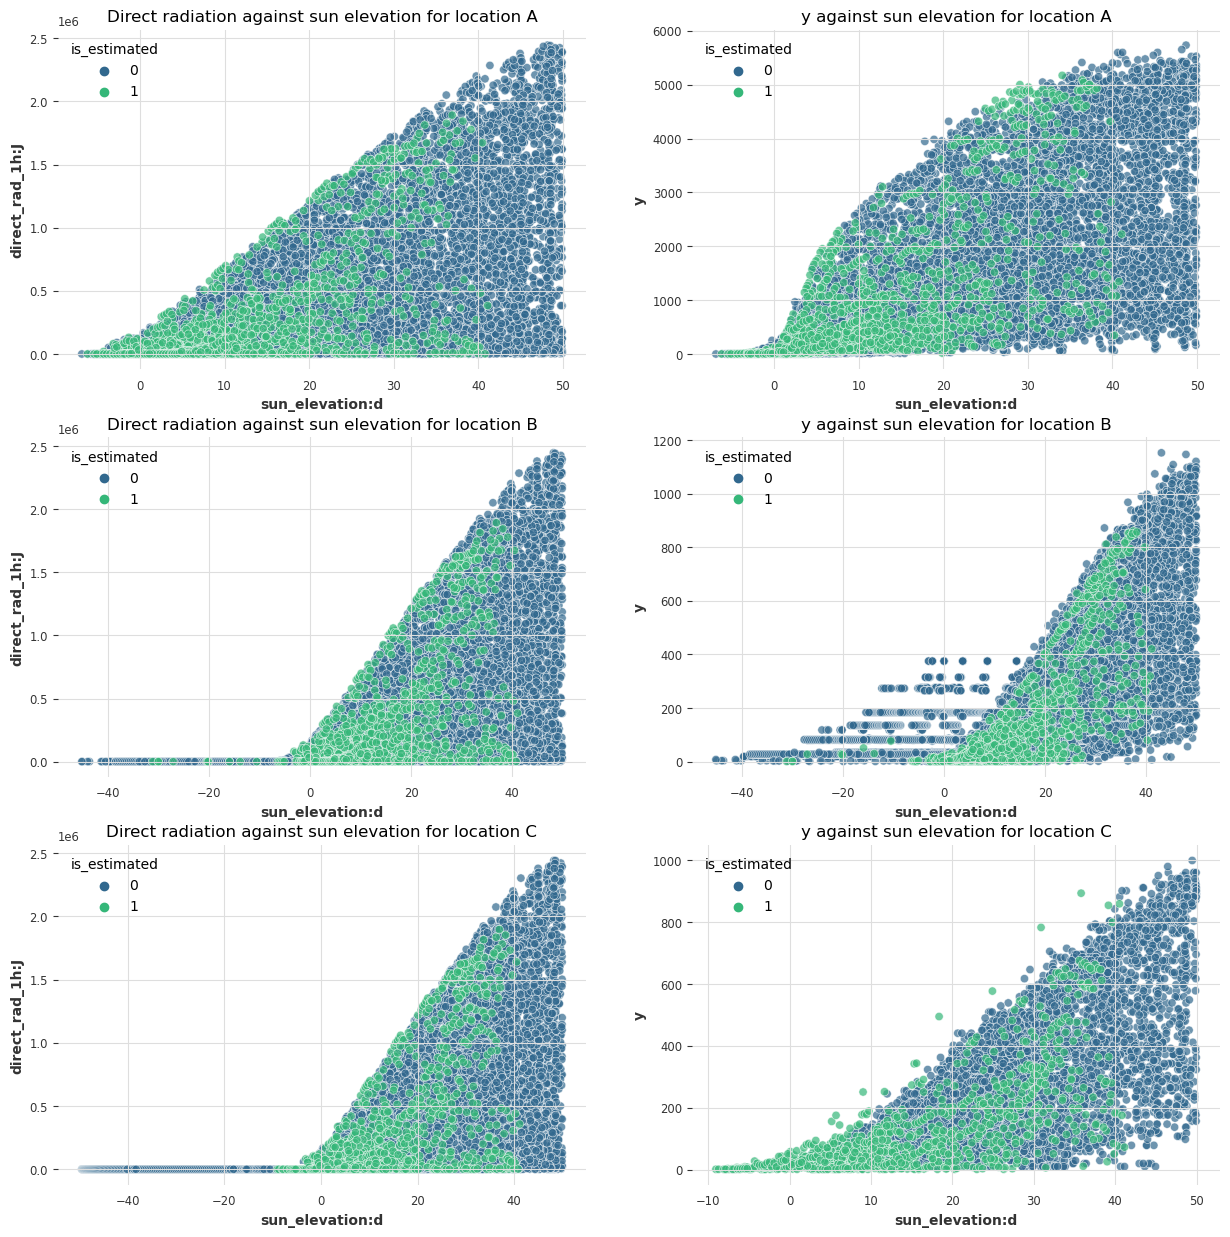

In [26]:
# Filter out rows where y == 0
temp = X_train[X_train["y"] != 0]

# Plotting
fig, axes = plt.subplots(len(locations), 2, figsize=(15, 5 * len(locations)))

for idx, location in enumerate(locations):
    sns.scatterplot(ax=axes[idx][0], data=temp[temp["location"] == location], x="sun_elevation:d", y="direct_rad_1h:J", hue="is_estimated", palette="viridis", alpha=0.7)
    axes[idx][0].set_title(f"Direct radiation against sun elevation for location {location}")
    
    sns.scatterplot(ax=axes[idx][1], data=temp[temp["location"] == location], x="sun_elevation:d", y="y", hue="is_estimated", palette="viridis", alpha=0.7)
    axes[idx][1].set_title(f"y against sun elevation for location {location}")

sun down -> no radiation

sun down -> still pv measurment in location B

here we can see that there are a lot of high values for pv_measurment even though the sun is not up. This is not intuitive, so we decided to remove these values.

In [27]:
# loop thorugh x train[y], keep track of streaks of same values and replace them with nan if they are too long
# also replace nan with 0
def replace_streaks_with_nan(df, max_streak_length, column="y"):
    for location in df["location"].unique():
        x = df[df["location"] == location][column].copy()

        last_val = None
        streak_length = 1
        streak_indices = []
        allowed = [0]
        found_streaks = {}

        for idx in x.index:
            value = x[idx]
            # if location == "B":
            #     continue

            if value == last_val and value not in allowed:
                streak_length += 1
                streak_indices.append(idx)
            else:
                streak_length = 1
                last_val = value
                streak_indices.clear()

            if streak_length > max_streak_length:
                found_streaks[value] = streak_length

                for streak_idx in streak_indices:
                    x[idx] = np.nan
                streak_indices.clear()  # clear after setting to NaN to avoid setting multiple times
        df.loc[df["location"] == location, column] = x

        print(f"Found streaks for location {location}: {found_streaks}")

    return df


# deep copy of X_train into x_copy
X_train = replace_streaks_with_nan(X_train.copy(), 3, "y")


def night_outliers(df):
    # set y to nan where y is 0, but direct_rad_1h:J or diffuse_rad_1h:J are > 0 (or some threshold)
    threshold_direct = df["direct_rad_1h:J"].max() * 0.01
    threshold_diffuse = df["diffuse_rad_1h:J"].max() * 0.01
    print(f"Threshold direct: {threshold_direct}")
    print(f"Threshold diffuse: {threshold_diffuse}")
    # print num rows
    temprows = len(df)
    df.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
    print("Dropped rows: ", temprows - len(df))

    mask = (df["y"] == 0) & ((df["direct_rad_1h:J"] > threshold_direct) | (df["diffuse_rad_1h:J"] > threshold_diffuse)) & (df["sun_elevation:d"] > 0) & (df["fresh_snow_24h:cm"] < 6) & (df[['fresh_snow_12h:cm', 'fresh_snow_1h:cm',  'fresh_snow_3h:cm', 'fresh_snow_6h:cm']].sum(axis=1) == 0)

    thresh = 0.1

    # Update "y" values to NaN if they don't meet the criteria
    mask = (df["direct_rad_1h:J"] <= thresh) & (df["diffuse_rad_1h:J"] <= thresh) & (df["y"] >= 0.1)
    if drop_night_outliers:
        df.loc[mask, "y"] = np.nan

    return df



X_train = night_outliers(X_train.copy())


def last_outliers(df):
# set y to nan where y is 0, but direct_rad_1h:J or diffuse_rad_1h:J are > 0 (or some threshold)
    threshold_direct = df["direct_rad_1h:J"].max() * 0.01
    threshold_diffuse = df["diffuse_rad_1h:J"].max() * 0.01
    print(f"Threshold direct: {threshold_direct}")
    print(f"Threshold diffuse: {threshold_diffuse}")

    mask = (df["y"] == 0) & ((df["direct_rad_1h:J"] > threshold_direct) | (df["diffuse_rad_1h:J"] > threshold_diffuse)) & (df["sun_elevation:d"] > 0) & (df["fresh_snow_24h:cm"] < 6) & (df[['fresh_snow_12h:cm', 'fresh_snow_1h:cm',  'fresh_snow_3h:cm', 'fresh_snow_6h:cm']].sum(axis=1) == 0)
    print(len(df[mask]))


    # set y to nan where mask
    if drop_null_outliers:
        df.loc[mask, "y"] = np.nan



    # show how many rows for each location, and for estimated and not estimated
    df[mask].groupby(["location", "is_estimated"]).count()["direct_rad_1h:J"]
    # print num rows
    df.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
    return df

X_train = last_outliers(X_train.copy())

def clip_target(df):
    df["y"] = df["y"].clip(lower=0)
    return df

# Clip target column
X_train = clip_target(X_train)

Found streaks for location A: {}
Found streaks for location B: {3.45: 28, 6.9: 7, 12.9375: 5, 13.8: 8, 276.0: 78, 18.975: 58, 0.8625: 4, 118.1625: 33, 34.5: 11, 183.7125: 1058, 87.1125: 7, 79.35: 34, 7.7625: 12, 27.6: 448, 273.41249999999997: 72, 264.78749999999997: 55, 169.05: 33, 375.1875: 56, 314.8125: 66, 76.7625: 10, 135.4125: 216, 81.9375: 202, 2.5875: 12, 81.075: 210}
Found streaks for location C: {9.8: 4, 29.400000000000002: 4, 19.6: 4}
Threshold direct: 24458.97
Threshold diffuse: 11828.035
Dropped rows:  9293
Threshold direct: 24458.97
Threshold diffuse: 11822.505000000001
2599


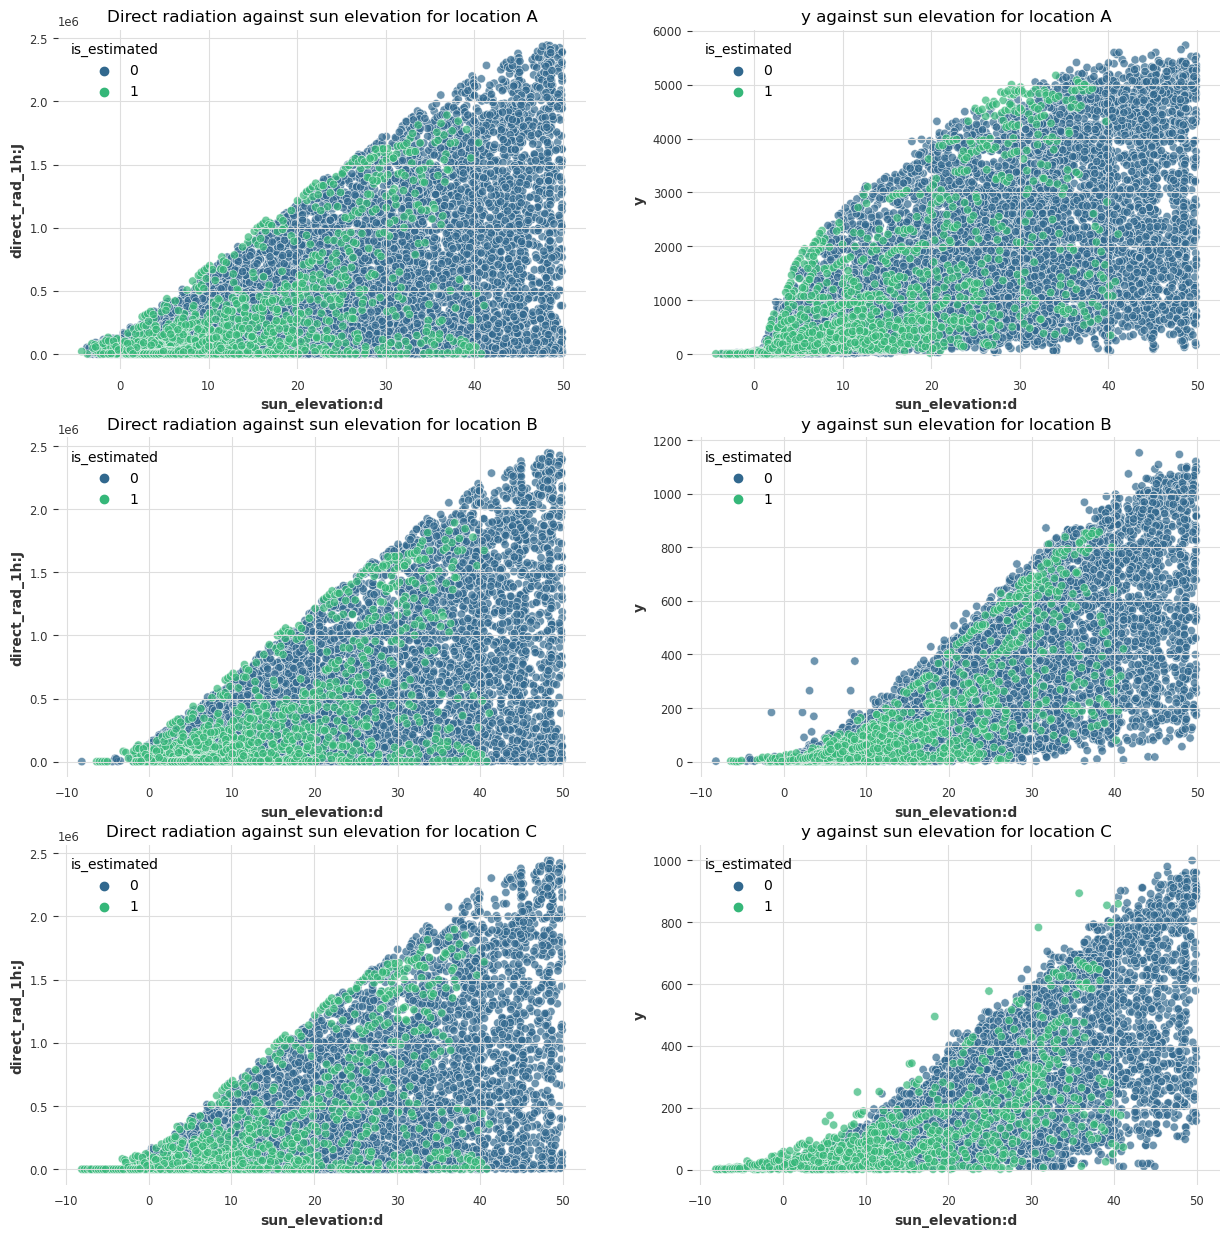

In [28]:
# Filter out rows where y == 0
temp = X_train[X_train["y"] != 0]

# Plotting
fig, axes = plt.subplots(len(locations), 2, figsize=(15, 5 * len(locations)))

for idx, location in enumerate(locations):
    sns.scatterplot(ax=axes[idx][0], data=temp[temp["location"] == location], x="sun_elevation:d", y="direct_rad_1h:J", hue="is_estimated", palette="viridis", alpha=0.7)
    axes[idx][0].set_title(f"Direct radiation against sun elevation for location {location}")
    
    sns.scatterplot(ax=axes[idx][1], data=temp[temp["location"] == location], x="sun_elevation:d", y="y", hue="is_estimated", palette="viridis", alpha=0.7)
    axes[idx][1].set_title(f"y against sun elevation for location {location}")

We can see that most of the outliers in location B have now been removed. There are still some values that may look like outliers, however these values are not as easy to classify as outliers so we keep them. It's also very few so we think it does not matter.

# Exploratory Data Analysis of the preprocessed data

Here all features are examined. Some combinations of features are also plotted where there is high correlation.

We can also see many missing values for these two especially
- snow_density:kgm3	95% missing ratio. We might want to remove this feature. 
- ceiling_height_agl:m	17% missing

From the plots we can see that some of the features are highly correlated, i.e. the pressure features. We have tried to only keep one of the features in these cases, but have not seen better performance. 

**`train_data` dataset summary**

count  unique top   freq           mean  \
absolute_humidity_2m:gm3        87917     759                   5.95345   
air_density_2m:kgm3             87917    1371                  1.255732   
ceiling_height_agl:m            72465   60284               2875.648926   
clear_sky_energy_1h:J           87917   46589                  518066.5   
clear_sky_rad:W                 87917   20079                143.783325   
cloud_base_agl:m                81501   61291               1737.502563   
dew_or_rime:idx                 87917       9                  0.005426   
dew_point_2m:K                  87917    1999                275.086578   
diffuse_rad:W                   87917   11089                 39.639839   
diffuse_rad_1h:J                87917   46535             143331.734375   
direct_rad:W                    87917   14133                 50.845604   
direct_rad_1h:J                 87917   40080              182954.28125   
effective_cloud_cover:p         87917    5666                 67.147171   
elevation:m                     87917       3                 11.637988   
fresh_snow_12h:cm               87917     125                  0.121152   
fresh_snow_1h:cm                87917      39                  0.010003   
fresh_snow_24h:cm               87917     161                  0.239474   
fresh_snow_3h:cm                87917      70                  0.030217   
fresh_snow_6h:cm                87917      96                  0.060474   
is_day:idx                      87917       5                  0.479907   
is_estimated                    87917       2                  0.121364   
is_in_shadow:idx                87917       5                  0.563665   
location                        87917       3   A  32780                  
msl_pressure:hPa                87917    3710               1009.330139   
precip_5min:mm                  87917     271                  0.005677   
precip_type_5min:idx            87917      15                   0.08636   
pressure_100m:hPa               87917    3730                995.609192   
pressure_50m:hPa                87917    3774               1001.741089   
prob_rime:p                     87917    1829                  0.773097   
rain_water:kgm2                 87917      39                  0.009377   
relative_humidity_1000hPa:p     87917    3832                 73.492676   
sfc_pressure:hPa                87917    3788               1007.900391   
snow_density:kgm3                4116       1                     250.0   
snow_depth:cm                   87917     490                  0.197459   
snow_drift:idx                  87917       4                  0.000023   
snow_melt_10min:mm              87917      66                  0.000288   
snow_water:kgm2                 87917     162                  0.090606   
sun_azimuth:d                   87917   83537                181.522049   
sun_elevation:d                 87917   73042                 -1.528149   
super_cooled_liquid_water:kgm2  87917      53                  0.056563   
t_1000hPa:K                     87917    1993                279.328125   
total_cloud_cover:p             87917    5552                 73.737526   
visibility:m                    87917   86366              33203.792969   
wind_speed_10m:ms               87917     594                  3.039212   
y                               87917   12340                 298.57167   

                                         std         min          25%  \
absolute_humidity_2m:gm3             2.68752         0.5          4.0   
air_density_2m:kgm3                 0.036675     1.13925       1.2305   
ceiling_height_agl:m             2521.869629   27.799999  1089.474976   
clear_sky_energy_1h:J               821476.5         0.0          0.0   
clear_sky_rad:W                   228.380005         0.0          0.0   
cloud_base_agl:m                 1799.804077        27.5   598.099976   
dew_or_rime:idx                     0.235273        -1.0          0.0 

**`test_data` dataset summary**

count  unique top  freq          mean  \
absolute_humidity_2m:gm3         2160     405                8.202084   
air_density_2m:kgm3              2160     570                1.232774   
ceiling_height_agl:m             1590    1531             3065.770508   
clear_sky_energy_1h:J            2106    1807               1259229.5   
clear_sky_rad:W                  2160    1233              341.040741   
cloud_base_agl:m                 1937    1890             1875.397461   
dew_or_rime:idx                  2160       9                0.036111   
dew_point_2m:K                   2160     661              280.778992   
diffuse_rad:W                    2160    1385               84.755867   
diffuse_rad_1h:J                 2106    1806            313548.09375   
direct_rad:W                     2160    1225               114.34198   
direct_rad_1h:J                  2106    1634              421957.875   
effective_cloud_cover:p          2160    1031               64.090988   
elevation:m                      2160       3               12.333333   
fresh_snow_12h:cm                2106       2                 0.00019   
fresh_snow_1h:cm                 2106       2                 0.00019   
fresh_snow_24h:cm                2106       2                 0.00019   
fresh_snow_3h:cm                 2106       2                 0.00019   
fresh_snow_6h:cm                 2106       2                 0.00019   
is_day:idx                       2160       5                0.793519   
is_estimated                     4608       1                     1.0   
is_in_shadow:idx                 2160       5                0.241204   
location                         4608       3   A  1536                 
msl_pressure:hPa                 2160     847             1016.780457   
precip_5min:mm                   2160      60                0.007663   
precip_type_5min:idx             2160       6                0.065972   
pressure_100m:hPa                2160     956             1002.946045   
pressure_50m:hPa                 2160     957             1008.982666   
prob_rime:p                      2160       5                0.016435   
rain_water:kgm2                  2160      20                0.013067   
relative_humidity_1000hPa:p      2160    1228               70.843506   
sfc_pressure:hPa                 2160     984             1015.044434   
snow_density:kgm3                   0       0                           
snow_depth:cm                    2160       1                     0.0   
snow_drift:idx                   2160       1                     0.0   
snow_melt_10min:mm               2160       1                     0.0   
snow_water:kgm2                  2160      48                0.060637   
sun_azimuth:d                    2160    2106              179.180542   
sun_elevation:d                  2160    1941               20.293179   
super_cooled_liquid_water:kgm2   2160      26                0.064525   
t_1000hPa:K                      2160     723              284.749359   
total_cloud_cover:p              2160     912               69.259583   
visibility:m                     2160    2159            33348.164062   
wind_speed_10m:ms                2160     323                2.945822   

                                         std          min           25%  \
absolute_humidity_2m:gm3            2.191512          3.2          6.65   
air_density_2m:kgm3                 0.032043      1.14275      1.209437   
ceiling_height_agl:m             2951.749023    46.450001    949.168701   
clear_sky_energy_1h:J            1100671.125          0.0  80204.453125   
clear_sky_rad:W                   306.855377          0.0      17.80625   
cloud_base_agl:m                 2093.077881       30.225    505.424988   
dew_or_rime:idx                      0.18285         -1.0           0.0   
dew_point_2m:K                      4.364164   268.075012    277.924988   
diffuse_rad:W                      78.432274          0.0         7.975

**Types warnings summary**

train_data test_data warnings
y      float        --  warning

### Feature Distance

**The following feature groups are considered as near-duplicates**:

Distance threshold: <= `0.01`. Consider keeping only some of the columns within each group:

 - `elevation:m`, `location` - distance `0.00`
 - `absolute_humidity_2m:gm3`, `dew_point_2m:K` - distance `0.00`
 - `snow_density:kgm3`, `snow_depth:cm` - distance `0.00`
 - `precip_5min:mm`, `precip_type_5min:idx` - distance `0.00`
 - `msl_pressure:hPa`, `pressure_100m:hPa`, `pressure_50m:hPa`, `sfc_pressure:hPa` - distance `0.00`

Feature interaction between `absolute_humidity_2m:gm3`/`dew_point_2m:K`

Feature interaction between `snow_density:kgm3`/`snow_depth:cm`

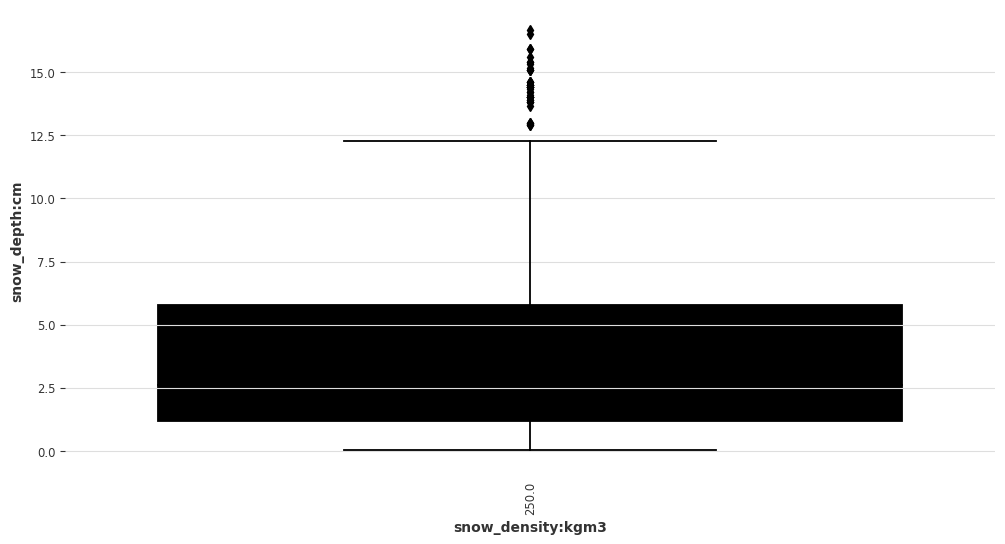

Feature interaction between `msl_pressure:hPa`/`pressure_100m:hPa`

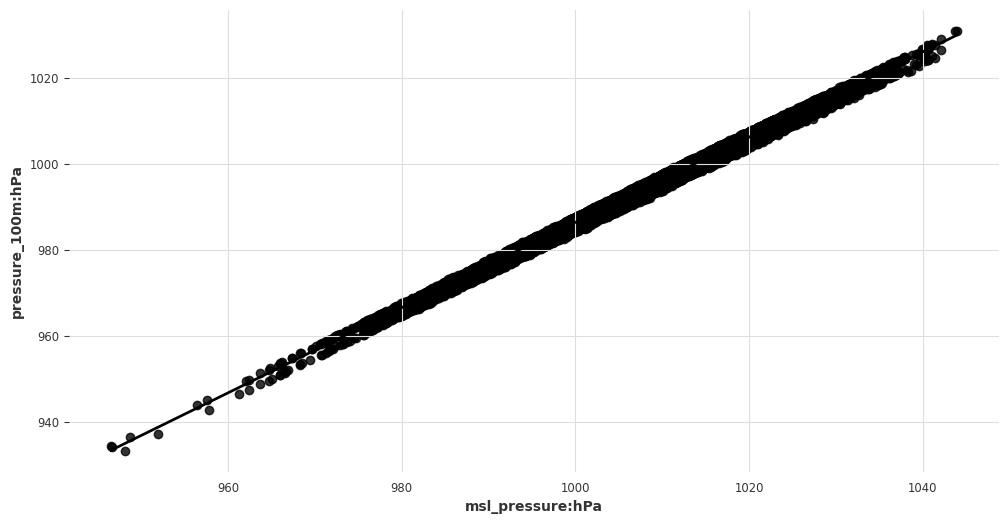

Feature interaction between `msl_pressure:hPa`/`pressure_50m:hPa`

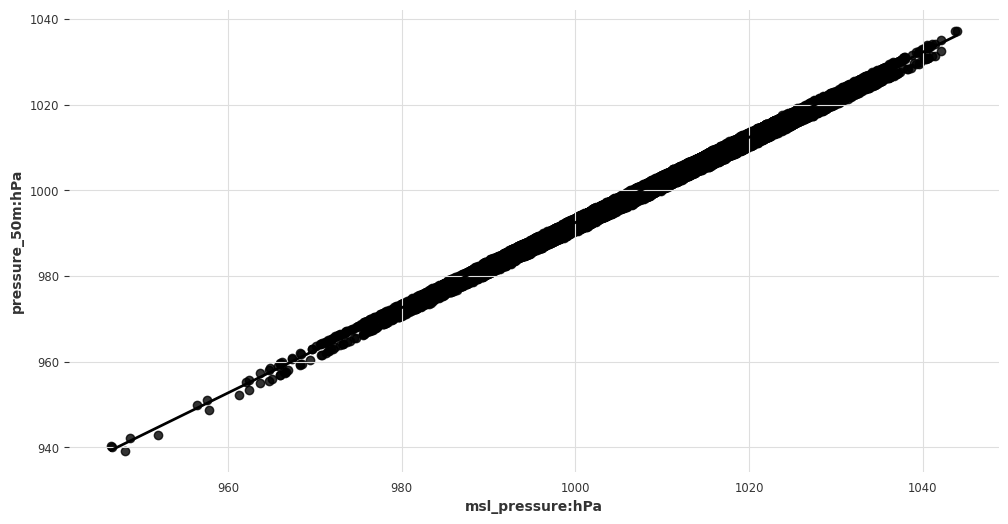

Feature interaction between `msl_pressure:hPa`/`sfc_pressure:hPa`

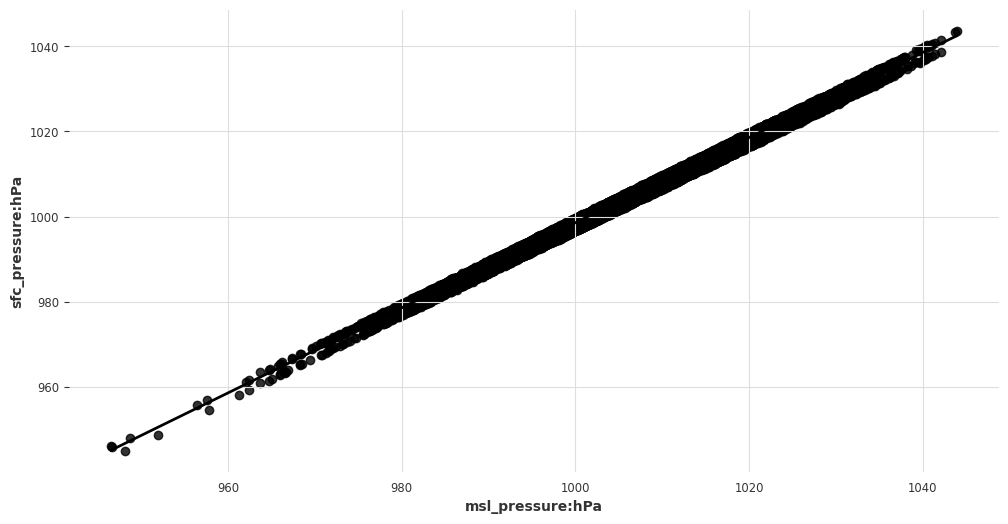

In [49]:
import autogluon.eda.auto as auto

auto.dataset_overview(train_data=X_train, test_data=X_test, label="y", sample=None)

### Visualize gaps in pv_measurment

Here we can see that the time series after preprocessing and removing anomalies. There are a ton of different intervals with gaps in between them. In the beginning we thought it would be possible to use time series forecasting for modelling this problem. However, there are two things that make this very hard. First is that there are a lot of gaps and some very large. The second is that the forecasting horison for the test data is two months and also has a lot of gaps in the weather features. This makes it totally unfeasable to do time series forecasting, so we use tabular regression instead and model it as an i.i.d. problem. 

In [41]:
from darts import TimeSeries
# workaround dropna
def create_multiple_non_nan_series(series, minimum_length=24*7):
    df = series.pd_dataframe()
    df.dropna(inplace=True)
    new_timeseries = TimeSeries.from_dataframe(df=df, freq="H", fill_missing_dates=False, fillna_value=None, value_cols=None)
    
    # Get the gaps DataFrame
    gaps_df = new_timeseries.gaps()
    
    # Create a list to store the resulting TimeSeries slices
    series_list = []
    
    # Initialize the start date for the first slice
    slice_start = new_timeseries.start_time()
    
    # Iterate through the rows in the gaps DataFrame
    for index, row in gaps_df.iterrows():
        gap_start, gap_end = row['gap_start'], row['gap_end']
        
        # Create a new slice from slice_start to gap_start - 1 freq
        slice_end = gap_start - pd.Timedelta(hours=1)
        sliced_series = new_timeseries.slice(slice_start, slice_end)
        #print(sliced_series.gaps(), "HEIEH",sliced_series.start_time(), sliced_series.end_time())
        #print(sliced_series.head(1))
        
        # Append the slice to the list
        if len(sliced_series) >= minimum_length:
            series_list.append(sliced_series)
        
        # Update slice_start for the next iteration
        slice_start = gap_end + pd.Timedelta(hours=1)
    
    # Handle the slice after the last gap
    slice_end = new_timeseries.end_time()
    sliced_series = new_timeseries.slice(slice_start, slice_end)
    #print(sliced_series.gaps(), "HEIEH",sliced_series.start_time(), sliced_series.end_time())
    series_list.append(sliced_series)
    
    return series_list

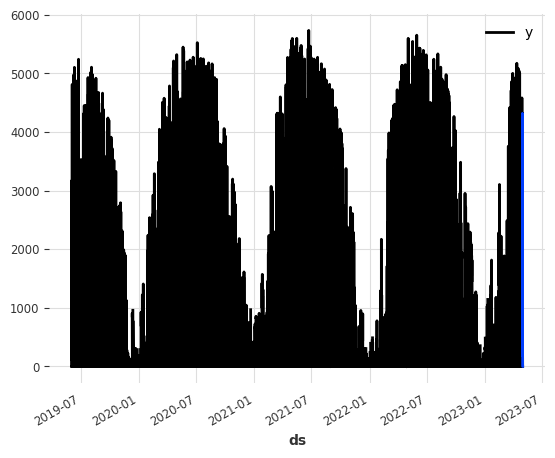

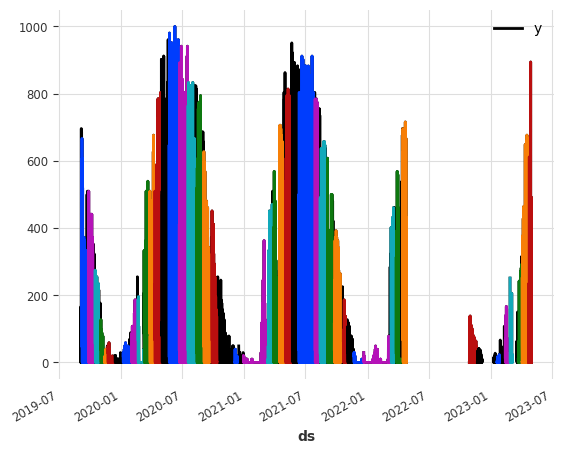

In [46]:
from darts import TimeSeries

train_series = TimeSeries.from_group_dataframe(df=X_train, group_cols=["location"], freq="H", fill_missing_dates=False, fillna_value=None, value_cols=None)

for i in range(len(locations)):
    y_train = train_series[i].univariate_component("y") # use these two lines if you want to use many different series without gap
    y_trains = create_multiple_non_nan_series(y_train)
    y_train.plot(new_plot=True)
    for section in y_trains:
        section.plot(label=None)

# train_series[i].univariate_component("y").plot(label=f"{i}_y_train", new_plot=True)

# Experiments 

Here we can see some code from earlier expiriments. We tried different approaches to improve the solution using autogluon. However, it did not improve the model in the end. This is not used in the final submissions, but we keep it here to show some of the process. sample weight was added to emphasise certain parts of the data, like the estimated data and the summer months (as these are the months in the test data). The use_groups part tried to add some time structure to the cross validation, but this did not work out as we had hoped to.

In [48]:
for attr in use_dt_attrs:
    X_train[attr] = getattr(X_train.index, attr)
    X_test[attr] = getattr(X_test.index, attr)


# If the "sample_weight" column is present and weight_evaluation is True, multiply sample_weight with sample_weight_may_july if the ds is between 05-01 00:00:00 and 07-03 23:00:00, else add sample_weight as a column to X_train
if weight_evaluation:
    if "sample_weight" not in X_train.columns:
        X_train["sample_weight"] = 1

    X_train.loc[((X_train.index.month >= 5) & (X_train.index.month <= 6)) | ((X_train.index.month == 7) & (X_train.index.day <= 3)), "sample_weight"] *= sample_weight_may_july
        
    
print(X_train[((X_train.index.month >= 5) & (X_train.index.month <= 6)) | ((X_train.index.month == 7) & (X_train.index.day <= 3))].head(1))


if use_groups:
    # fix groups for cross validation
    locations = X_train['location'].unique()  # Assuming 'location' is the name of the column representing locations

    grouped_dfs = []  # To store data frames split by location

    # Loop through each unique location
    for loc in locations:
        loc_df = X_train[X_train['location'] == loc]
        
        # Sort the DataFrame for this location by the time column
        loc_df = loc_df.sort_index()
        
        # Calculate the size of each group for this location
        group_size = len(loc_df) // n_groups
        
        # Create a new 'group' column for this location
        loc_df['group'] = np.repeat(range(n_groups), repeats=[group_size]*(n_groups-1) + [len(loc_df) - group_size*(n_groups-1)])
        
        # Append to list of grouped DataFrames
        grouped_dfs.append(loc_df)

    # Concatenate all the grouped DataFrames back together
    X_train = pd.concat(grouped_dfs)
    X_train.sort_index(inplace=True)
    print(X_train["group"].head())

                     absolute_humidity_2m:gm3  air_density_2m:kgm3  \
ds                                                                   
2019-06-02 23:00:00                       7.7               1.2235   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
ds                                                                 
2019-06-02 23:00:00           1689.824951                    0.0   

                     clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  \
ds                                                                        
2019-06-02 23:00:00              0.0       1689.824951              0.0   

                     dew_point_2m:K  diffuse_rad:W  diffuse_rad_1h:J  ...  \
ds                                                                    ...   
2019-06-02 23:00:00      280.299988            0.0               0.0  ...   

                     sun_azimuth:d  sun_elevation:d  \
ds                                                    
2019-06-02 23:00

# Feature selection

In [32]:
# See config for variable declaration
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

# Split handling

This is how we initially handled the splitting of the data before modelling. Some portion of the estimated data was used for training and some was used for validation and testing. Estimated data was used for validation to make the model adapt to the distribution of the estimated set, as this is hopefully the same distribution as the test. 

In [33]:
# Create a plot of X_train showing its "y" and color it based on the value of the sample_weight column.
if "sample_weight" in X_train.columns:
    sns.scatterplot(data=X_train, x=X_train.index, y="y", hue="sample_weight", palette="deep", size=3)
    plt.show()

In [34]:
def normalize_sample_weights_per_location(df):
    for loc in locations:
        loc_df = df[df["location"] == loc]
        loc_df["sample_weight"] = loc_df["sample_weight"] / loc_df["sample_weight"].sum() * loc_df.shape[0]
        df[df["location"] == loc] = loc_df
    return df

def split_and_shuffle_data(input_data, num_bins, frac1):
    """
    Splits the input_data into num_bins and shuffles them, then divides the bins into two datasets based on the given fraction for the first set.

    Args:
        input_data (pd.DataFrame): The data to be split and shuffled.
        num_bins (int): The number of bins to split the data into.
        frac1 (float): The fraction of each bin to go into the first output dataset.

    Returns:
        pd.DataFrame, pd.DataFrame: The two output datasets.
    """
    # Validate the input fraction
    if frac1 < 0 or frac1 > 1:
        raise ValueError("frac1 must be between 0 and 1.")
    
    if frac1==1:
        return input_data, pd.DataFrame()

    # Calculate the fraction for the second output set
    frac2 = 1 - frac1
    
    # Calculate bin size
    bin_size = len(input_data) // num_bins

    # Initialize empty DataFrames for output
    output_data1 = pd.DataFrame()
    output_data2 = pd.DataFrame()

    for i in range(num_bins):
        # Shuffle the data in the current bin
        np.random.seed(i)
        current_bin = input_data.iloc[i * bin_size: (i + 1) * bin_size].sample(frac=1)
        
        # Calculate the sizes for each output set
        size1 = int(len(current_bin) * frac1)
        
        # Split and append to output DataFrames
        output_data1 = pd.concat([output_data1, current_bin.iloc[:size1]])
        output_data2 = pd.concat([output_data2, current_bin.iloc[size1:]])

    # Shuffle and split the remaining data
    remaining_data = input_data.iloc[num_bins * bin_size:].sample(frac=1)

    remaining_size1 = int(len(remaining_data) * frac1)
    
    output_data1 = pd.concat([output_data1, remaining_data.iloc[:remaining_size1]])
    output_data2 = pd.concat([output_data2, remaining_data.iloc[remaining_size1:]])

    return output_data1, output_data2


In [35]:
data = TabularDataset('X_train_raw.csv')
# set group column of train_data be increasing from 0 to 7 based on time, the first 1/8 of the data is group 0, the second 1/8 of the data is group 1, etc.
data['ds'] = pd.to_datetime(data['ds'])
data = data.sort_values(by='ds')

# # print size of the group for each location
# for loc in locations:
#     print(f"Location {loc}:")
#     print(train_data[train_data["location"] == loc].groupby('group').size())


# get end date of train data and subtract 3 months
#split_time = pd.to_datetime(train_data["ds"]).max() - pd.Timedelta(hours=tune_and_test_length)
# 2022-10-28 22:00:00
split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(data[data["ds"] < split_time])
estimated_set = TabularDataset(data[data["ds"] >= split_time]) # only estimated

test_set = pd.DataFrame()
tune_set = pd.DataFrame()
new_train_set = pd.DataFrame()

if not use_tune_data:
    raise Exception("Not implemented")
    
for location in locations:
    loc_data = data[data["location"] == location]
    num_train_rows = len(loc_data)
    
    tune_rows = 1500.0 # 2500.0
    if use_test_data:
        tune_rows = 1880.0#max(3000.0, len(estimated_set[estimated_set["location"] == location]))

    holdout_frac = max(0.01, min(0.1, tune_rows / num_train_rows)) * num_train_rows / len(estimated_set[estimated_set["location"] == location])

    print(f"Size of estimated for location {location}: {len(estimated_set[estimated_set['location'] == location])}. Holdout frac should be % of estimated: {holdout_frac}")

    # shuffle and split data
    loc_tune_set, loc_new_train_set = split_and_shuffle_data(estimated_set[estimated_set['location'] == location], 40, holdout_frac)
    print(f"Length of location tune set : {len(loc_tune_set)}")
    new_train_set = pd.concat([new_train_set, loc_new_train_set])

    if use_test_data:
        loc_test_set, loc_tune_set = split_and_shuffle_data(loc_tune_set, 40, 0.2)
        test_set = pd.concat([test_set, loc_test_set])

    tune_set = pd.concat([tune_set, loc_tune_set])




print("Length of train set before adding test set", len(train_set))
# add rest to train_set
train_set = pd.concat([train_set, new_train_set])
print("Length of train set after adding test set", len(train_set))




if use_groups:
    test_set = test_set.drop(columns=['group'])


tuning_data = tune_set

# number of rows in tuning data for each location
print("Shapes of tuning data", tuning_data.groupby('location').size())


    
if use_test_data:
    test_data = test_set
    print("Shape of test", test_data.shape[0])


train_data = train_set

# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
if weight_evaluation:
    # ensure sample weights for data sum to the number of rows in the tuning /train data.
    tuning_data = normalize_sample_weights_per_location(tuning_data)
    train_data = normalize_sample_weights_per_location(train_data)
    if use_test_data:
        test_data = normalize_sample_weights_per_location(test_data)


train_data = TabularDataset(train_data)
tuning_data = TabularDataset(tuning_data)

if use_test_data:
    test_data = TabularDataset(test_data)

Size of estimated for location A: 4214. Holdout frac should be % of estimated: 0.4461319411485524
Length of location tune set : 1846
Size of estimated for location B: 3533. Holdout frac should be % of estimated: 0.5321256722332296
Length of location tune set : 1846
Size of estimated for location C: 2923. Holdout frac should be % of estimated: 0.6431748203900103
Length of location tune set : 1841
Length of train set before adding test set 77247
Length of train set after adding test set 82384
Shapes of tuning data location
A    1485
B    1485
C    1481
dtype: int64
Shape of test 1082


# New handling of spilt with multiple seeds trained at once

We found a more clean and robust way of splitting using train_test split and sklearn and using stratified splitting. Stratified splitting was used to get a similar sample of the estimated data in both train and validation. 

In [ ]:
from sklearn.model_selection import train_test_split
def strat_split(x, test_size=0.2, seed=42):
    # create stratified column, location, week, y (mapped to boolean, 0 or bigger)
    strat = x["location"] + "_" + x["ds"].dt.week.astype('str') + "_" + x["y"].apply(lambda x: 0 if x == 0 else 1).astype('str')
    print(f"Number of unique strats: {len(strat.unique())}")
    print(f"Lengt of strat: {len(strat)}")

    # check if there are any strats with only one row
    for s in strat.unique():
        if len(x[strat == s]) == 1:
            print(f"Strat {s} has only one row")
            # set equal to another strat with more rows
            strat[strat == s] = strat.unique()[0]

    # split
    train, test = train_test_split(x, test_size=test_size, random_state=seed, stratify=strat)
    

    return train, test

data = TabularDataset('X_train_raw.csv')
data['ds'] = pd.to_datetime(data['ds'])
data = data.sort_values(by='ds')


split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(data[data["ds"] < split_time])
estimated_set = TabularDataset(data[data["ds"] >= split_time]) # only estimated

test_sets = [pd.DataFrame()]*num_seeds
tune_sets = [pd.DataFrame()]*num_seeds
new_train_sets = [pd.DataFrame()]*num_seeds

if not use_tune_data:
    raise Exception("Not implemented")
    

for location in locations:
    loc_data = data[data["location"] == location]
    num_train_rows = len(loc_data)
    
    tune_rows = 1500.0 # 2500.0
    if use_test_data:
        tune_rows = 1880.0#max(3000.0, len(estimated_set[estimated_set["location"] == location]))

    # 3 different seeds
    for i in range(num_seeds):
        holdout_frac = max(0.01, min(0.1, tune_rows / num_train_rows)) * num_train_rows / len(estimated_set[estimated_set["location"] == location])

        print(f"Size of estimated for location {location}: {len(estimated_set[estimated_set['location'] == location])}. Holdout frac should be % of estimated: {holdout_frac}")

    
        loc_new_train_set, loc_tune_set = strat_split(estimated_set[estimated_set["location"] == location], holdout_frac, seed=i)
        new_train_sets[i] = pd.concat([new_train_sets[i], loc_new_train_set])

        if use_test_data:
            loc_tune_set, loc_test_set = strat_split(loc_tune_set, 0.2, seed=i+1)
            test_sets[i] = pd.concat([test_sets[i], loc_test_set])

        tune_sets[i] = pd.concat([tune_sets[i], loc_tune_set])



train_data_list = [pd.concat([train_set, new_train_set]) for new_train_set in new_train_sets]
print("Length of train set after adding test set", len(train_set))




if use_groups:
    test_set = test_set.drop(columns=['group'])


tuning_data_list = tune_sets

# number of rows in tuning data for each location
for i in range(num_seeds):
    print("Shapes of tuning data", tuning_data_list[i].groupby('location').size())


    
test_data_list = [pd.DataFrame()]*num_seeds
if use_test_data:
    test_data_list = test_sets
    for i in range(num_seeds):
        print("Shape of test", test_data_list[i].shape[0])



# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
if weight_evaluation:
    # ensure sample weights for data sum to the number of rows in the tuning /train data.
    tuning_data = normalize_sample_weights_per_location(tuning_data)
    train_data = normalize_sample_weights_per_location(train_data)
    if use_test_data:
        test_data = normalize_sample_weights_per_location(test_data)


train_data_list = [TabularDataset(train_data) for train_data in train_data_list]
tuning_data_list = [TabularDataset(tuning_data) for tuning_data in tuning_data_list]

if use_test_data:
    test_data_list = [TabularDataset(test_data) for test_data in test_data_list]

# Modelling

Here we include two of the approaches we have tried. Our thought is that you can just collapse the approaches as you go through them.

Both approaches use ensambles of different models. In the first approach we use a naive ensable (mean) of XGBoost, CatBoost and LightGBM. In the second approach we train different models, including XGBoost, CatBoost, LightGBM, Random Forest, KNN  and different neural networks. A weighted ensamble is then trained to give weights to the different models (a form of stacking). Additionaly, each spesific model use bag ensambling. 

## Custom tabular models with darts

Before discovering auto gluon we experimented with ensambles of tabular models using the darts framework. An ensamble with XGBoost, lightGBM and CatBoost resulted in a score of ~155. This modelling is from before some of the cleaning that is further up in this notebook. These models could probably have resulted in much better scores with smarter approaches, as we have since learned a lot about the domain and machine learning in general.

Shape of y_train before dropping gaps: (34274, 1)
Shape of y_train after dropping gaps: (34274, 1)
Shape of y_train before dropping gaps: (37945, 1)
Shape of y_train after dropping gaps: (37945, 1)
Shape of y_train before dropping gaps: (37945, 1)
Shape of y_train after dropping gaps: (37945, 1)


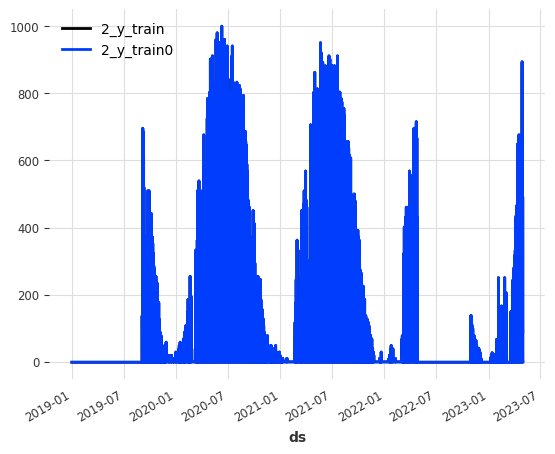

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# from darts.dataprocessing.transformers import Scaler, BoxCox

# store the data in list
y_trains_list = []
covariate_trains_list = []


mode = "longest_series_without_gap" # "many_series_without_gap" "longest_series_without_gap"
#mode = "many_series_without_gap" # "many_series_without_gap" "longest_series_without_gap"
one_model_for_all = False
is_single_gbtree_model=False
use_validation_set = True
train_val_split = pd.Timestamp("2023-02-01 00:00:00")
use_gridsearch = False
forecast_horizon = len(covariate_future[0])
stride = forecast_horizon
start=0.5
model_name="ensemble003"
use_naive_ensemble=True
models_to_train = [
    ["xgb", "catboost"],
    ["catboost", "rforest"],
    ["xgb", "catboost"],
    ]

use_all_even_with_missing = False # doesnt work

predict_multivariate = False # if to predict only y, or all exogenous variables as well

for i in range(len(train_series)):
    if mode == "many_series_without_gap":
        # seperate into y_train and covariate_train
        y_train = train_series[i].univariate_component("y") # use these two lines if you want to use many different series without gap
        y_trains = create_multiple_non_nan_series(y_train)

    elif mode == "longest_series_without_gap":
        # get longest series without gap
        print("Shape of y_train before dropping gaps:", train_series[i].univariate_component("y").pd_dataframe().shape)
        print("Shape of y_train after dropping gaps:", train_series[i].univariate_component("y").longest_contiguous_slice().pd_dataframe().shape)
        y_trains = [train_series[i].univariate_component("y").longest_contiguous_slice()]

    covariate_train = train_series[i].drop_columns(["y"])
    covariate_trains = [covariate_train.slice_intersect(yt) for yt in y_trains]

    if use_all_even_with_missing:
        y_trains=[train_series[i].univariate_component("y")]
        covariate_trains=[train_series[i].drop_columns(["y"])]
        



    y_trains_list.append(y_trains[0] if mode == "longest_series_without_gap" else y_trains)
    covariate_trains_list.append(covariate_trains[0] if mode == "longest_series_without_gap" else covariate_trains)


    train_series[i].univariate_component("y").plot(label=f"{i}_y_train", new_plot=True)


    
    for j in range(len(y_trains)):
        y_trains[j].plot(label=f"{i}_y_train{j}", new_plot=False)


In [ ]:
from darts.models import (
    XGBModel,
    RegressionEnsembleModel,
    LightGBMModel,
    NaiveEnsembleModel,
    CatBoostModel,
    RandomForest,
    NBEATSModel,
    TiDEModel,
)
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.metrics import mae
# get the torch mae equivalent
from darts.utils.losses import MAELoss

add_encoders = {
    #'cyclic': {'future': ['hour', 'month']},
    "datetime_attribute": {"future": ["hour", "month"]},
    # 'position': {'past': ['relative'], 'future': ['relative']},
    # 'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    # "transformer": Scaler(),
}

# best for A
# Best parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.03, 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'random_state': 42, 'lags': [-2400], 'lags_future_covariates': [0], 'add_encoders': {'datetime_attribute': {'future': ['hour', 'month']}, 'transformer': Scaler}}

# best for B
# Best parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'random_state': 42, 'lags': [-2400], 'lags_future_covariates': [0], 'add_encoders': {'datetime_attribute': {'future': ['hour', 'month']}, 'transformer': Scaler}}

# best for C
# Best parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.03, 'objective': 'reg:absoluteerror', 'booster': 'gbtree', 'random_state': 42, 'lags': [-2400], 'lags_future_covariates': [0], 'add_encoders': {'datetime_attribute': {'future': ['hour', 'month']}, 'transformer': Scaler}}


parameters_dict = {
    "XGBModel": {
        "n_estimators": [500],
        "max_depth": [6],
        "learning_rate": [0.03],
        "objective": ["reg:absoluteerror"],
        "booster": ["gbtree"],
        "random_state": [42],
        "lags": [[-24 * 365]],
        "lags_future_covariates": [[0]],
        "add_encoders": [add_encoders],
    },
    "LightGBMModel": {
        "n_estimators": [700, 300, 500, 1000, 1500],
        "max_depth": [6, 5, 7, 8, 13], 
        "learning_rate": [0.01, 0.1, 0.03],
        "objective": ["regression"],
        "random_state": [42],
        "lags": [[-24 * 365]],
        "lags_future_covariates": [[0]],
        "add_encoders": [add_encoders],
        "verbose": [-1],  # -1 for no output
        # "use_missing": [False],
        # "zero_as_missing": [True],
    },
    "CatBoostModel": {
        "n_estimators": [500, 300, 700, 1000],
        "max_depth": [6],#, 5, 7, 8, 13],
        "learning_rate": [0.03, 0.01],
        "objective": ["MAE"],
        "random_state": [42],
        "lags": [[-24 * 365]],
        "lags_future_covariates": [[0]],
        "add_encoders": [add_encoders],
        # "nan_mode": ["Min"],
    },
    "RandomForest": {
        #"n_estimators": [400],
        #"max_depth": [None],
        # "min_samples_split": [2, 5],
        # "min_samples_leaf": [1, 4],
        # "criterion": ["absolute_error"],
        # # "random_state": [42],
        "max_features": ["sqrt"],#, None],
        # #"oob_score": [True, False],
        "bootstrap": [True],
        "lags": [[-24 * 365]],
        "lags_future_covariates": [[0]],
        "add_encoders": [add_encoders],
    },
}

locations_override = {
    "XGBModel": [{}, {"learning_rate": 0.03}, {}],
    "LightGBMModel": [{}, {"n_estimators": 300, "learning_rate": 0.03}, {"max_depth": 13}],
    "CatBoostModel": [{}, {}, {}],
    "RandomForest": [{}, {}, {}],
}


def create_model(location, name):
    if name == "xgb":
        return XGBModel(**{**{k: v[0] for k, v in parameters_dict["XGBModel"].items()}, **locations_override["XGBModel"][location]})

    elif name == "lgbm":
        return LightGBMModel(**{**{k: v[0] for k, v in parameters_dict["LightGBMModel"].items()}, **locations_override["LightGBMModel"][location]})

    elif name == "catboost":
        return CatBoostModel(**{**{k: v[0] for k, v in parameters_dict["CatBoostModel"].items()}, **locations_override["CatBoostModel"][location]})
    
    elif name == "rforest":
        return RandomForest(**{**{k: v[0] for k, v in parameters_dict["RandomForest"].items()}, **locations_override["RandomForest"][location]})

    elif name == "tide":
        tide = TiDEModel(input_chunk_length=1, output_chunk_length=24, add_encoders=add_encoders, pl_trainer_kwargs={"accelerator": "cpu"}, loss_fn=MAELoss)
        return tide

def create_ensemble_model(models):
    # assumes already trained models

    if use_naive_ensemble:
        return NaiveEnsembleModel(
            forecasting_models=models,
            train_forecasting_models=False,
        )

    return RegressionEnsembleModel(
        forecasting_models=models,
        regression_train_n_points=int(len(y_trains_list[0])/20),
        train_forecasting_models=False,
        #train_using_historical_forecasts=True,
    )


def backtest(model, y, cov, start):
    return model.backtest(
        series=y,
        future_covariates=cov,
        start=start,
        forecast_horizon=forecast_horizon,
        stride=stride,
        retrain=False,
        metric=mae,
    )

def mae_last_half_of_train(model, y_train, cov):
    s = int(len(y_train)/2)
    backtest = model.predict(
        s,
        series=y_train.head(len(y_train)-s),   
        future_covariates=cov
    )
    return mae(y_train.tail(s), backtest)

models = []
validation_mae = []






if mode == "longest_series_without_gap" and one_model_for_all:
    # create validation and train set
    models_trained = []
    for model_to_train in models_to_train[0]:
        model = create_model(location=0, name=model_to_train)
        if use_validation_set:
            target_trains, target_vals, cov_trains, cov_vals = [], [], [], []
            for i in range(len(y_trains_list)):
                target_train, target_val = y_trains_list[i].split_before(train_val_split)
                cov_train, cov_val = covariate_trains_list[i].split_before(train_val_split)
                target_trains.append(target_train)
                target_vals.append(target_val)
                cov_trains.append(cov_train)
                cov_vals.append(cov_val)

            model.fit(series=target_trains, future_covariates=cov_trains)
            for i in range(len(y_trains_list)):
                pred_val = model.predict(
                    len(target_vals[i]),
                    series=target_trains[i],
                    future_covariates=covariate_trains_list[i],
                )
                print("Validation MAE:", mae(target_vals[i], pred_val))

                target_vals[i].plot(label="Target", new_plot=True)
                pred_val.plot(label="Predictions")
                
                print("Backtest mean MAE:", mae_last_half_of_train(model, target_trains[i], covariate_trains_list[i]))

        else:
            model.fit(series=y_trains_list, future_covariates=covariate_trains_list)

            for i in range(len(backtests)):
                print("Backtest mean MAE:", mae_last_half_of_train(model, y_trains_list[i], covariate_trains_list[i]))

        models_trained.append(model)    

    if len(models_trained) == 1:
        models = [model, model, model]
    else:
        # create ensmble
        ensemble_model = create_ensemble_model(models_trained)
        ensemble_model.fit(series=y_trains_list, future_covariates=covariate_trains_list)
        for i in range(len(y_trains_list)):
            print("Ensemble backtest mean MAE:", mae_last_half_of_train(ensemble_model, y_trains_list[i], covariate_trains_list[i]))

        models = [ensemble_model, ensemble_model, ensemble_model]



elif mode == "longest_series_without_gap" and not one_model_for_all:
    models = []
    for i in range(len(y_trains_list)):
        print(i)
        
        models_trained = []
        for model_to_train in models_to_train[i]:
            model = create_model(location=i, name=model_to_train)

            m = type(model)
            print("Model:", m, m.__name__)


            if use_gridsearch:
                model, best_parameters, best_score = m.gridsearch(
                        parameters=parameters_dict[m.__name__],
                        series=y_trains_list[i],
                        future_covariates=covariate_trains_list[i],
                        # val_series=target_val,
                        show_warnings=True,
                        verbose=True,
                        metric=mae,
                        forecast_horizon=forecast_horizon,
                        stride=stride,
                    )
                print("BEST SCORE is:", best_score)
                print("Best parameters:", best_parameters)
                # print("MODEL:", model)
                print("Now fitting model with best parameters")
                model.fit(
                    series=y_trains_list[i], future_covariates=covariate_trains_list[i]
                )
                print("Backtest mean MAE:", mae_last_half_of_train(model, y_trains_list[i], covariate_trains_list[i]))

            if not use_gridsearch:
                if use_validation_set:
                    target_train, target_val = y_trains_list[i].split_before(train_val_split)
                    cov_train, cov_val = covariate_trains_list[i].split_before(train_val_split)
                    # print(cov_train.pd_dataframe().shape, target_train.pd_dataframe().shape)
                    # print(cov_val.pd_dataframe().shape, target_val.pd_dataframe().shape)
                    # print(
                    #     "Start and end dates of train set:",
                    #     target_train.start_time(),
                    #     target_train.end_time(),
                    # )
                    # print(
                    #     "Start and end dates of validation set:",
                    #     target_val.start_time(),
                    #     target_val.end_time(),
                    # )

                    if predict_multivariate:
                        model.fit(
                            series=train_series[i].slice_intersect(target_train),
                            future_covariates=cov_train,
                        )
                        all_predictions = model.predict(
                            len(target_val),
                            future_covariates=cov_train.concatenate(cov_val),
                            series=train_series[i].slice_intersect(target_train),
                        )
                        pred_val = all_predictions.univariate_component("y")
                    else:
                        model.fit(series=target_train, future_covariates=cov_train)
                        pred_val = model.predict(
                            len(target_val),
                            future_covariates=covariate_trains_list[i],
                            series=target_train,
                        )

                    print("Validation MAE:", mae(target_val, pred_val))

                    # target_val.plot(label="Target", new_plot=True)
                    # pred_val.plot(label=f"{model_to_train} location {i}")

                    print("Backtest mean MAE:", mae_last_half_of_train(model, target_train, cov_train))
                else:
                    model.fit(
                        series=y_trains_list[i], future_covariates=covariate_trains_list[i]
                    )

                    print("Backtest mean MAE:", mae_last_half_of_train(model, y_trains_list[i], covariate_trains_list[i]))

            models_trained.append(model)

        if len(models_trained) == 1:
            models.append(models_trained[0])

        else:
            # create ensmble
            #ensemble_model = create_ensemble_model(models_trained)
            ensemble_model = create_ensemble_model(models_trained)
            if use_validation_set:
                ensemble_model.fit(series=target_train, future_covariates=cov_train)
                pred_val = ensemble_model.predict(
                    len(target_val),
                    future_covariates=covariate_trains_list[i],
                    series=target_train,
                )
                print("Ensemble validation set MAE:", mae(target_val, pred_val))
                # target_val.plot(label="Target", new_plot=True)
                # pred_val.plot(label=f"Predictions for location {i}, ensemble model")
                print("Ensemble backtest MAE:", mae_last_half_of_train(ensemble_model, target_train, cov_train))
                
            else:
                ensemble_model.fit(series=y_trains_list[i], future_covariates=covariate_trains_list[i])
                print("Ensemble backtest MAE:", mae_last_half_of_train(ensemble_model, y_trains_list[i], covariate_trains_list[i]))

            models.append(ensemble_model)

        


# elif mode == "many_series_without_gap" and one_model_for_all:
#     model = create_model()
#     for i in range(3):
#         y_trains = y_trains_list[i]
#         for j in range(len(y_trains)):
#             print(i, j)
#             model.fit(y_trains[j], future_covariates=covariate_trains[j], verbose=True)

# elif mode == "many_series_without_gap" and not one_model_for_all:
#     models = []
#     for i in range(3):
#         y_trains = y_trains_list[i]
#         model = create_model()
#         for j in range(len(y_trains)):
#             print(i, j)
#             model.fit(y_trains[j], future_covariates=covariate_trains[j], verbose=True)

#         models.append(model)

0
Model: <class 'darts.models.forecasting.xgboost.XGBModel'> XGBModel
Validation MAE: 195.95260046906316
Backtest mean MAE: 182.93240268939144
Model: <class 'darts.models.forecasting.catboost_model.CatBoostModel'> CatBoostModel
Validation MAE: 204.08920360646974
Backtest mean MAE: 205.52065014688205
Ensemble validation set MAE: 198.30355604303037
Ensemble backtest MAE: 192.61519541369032
1
Model: <class 'darts.models.forecasting.catboost_model.CatBoostModel'> CatBoostModel
Validation MAE: 43.720892376517305
Backtest mean MAE: 25.884285539134584
Model: <class 'darts.models.forecasting.random_forest.RandomForest'> RandomForest
Validation MAE: 45.016834919693274
Backtest mean MAE: 9.62788714391279
Ensemble validation set MAE: 43.41489470001597
Ensemble backtest MAE: 17.527686054432028
2
Model: <class 'darts.models.forecasting.xgboost.XGBModel'> XGBModel
Validation MAE: 22.393901724770657
Backtest mean MAE: 12.92215954959796
Model: <class 'darts.models.forecasting.catboost_model.CatBoostMo

In [ ]:
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot feature importance
def plot_feature_importance(model, train_data, location):
    gain= model.get_booster().get_score(importance_type="gain")
    weight = model.get_booster().get_score(importance_type="weight")

    #plot_importance(model, title=f"Feature importance for {location} (weigth: number of times used)")

    feature_importance_gain = [(col, gain[f"f{i}"] if f"f{i}" in gain else 0) for i, col in enumerate(train_data.columns)]
    feature_importance_gain = sorted(feature_importance_gain, key=lambda x: x[1], reverse=False)

    feature_importance_weight = [(col, weight[f"f{i}"] if f"f{i}" in weight else 0) for i, col in enumerate(train_data.columns)]
    feature_importance_weight = sorted(feature_importance_weight, key=lambda x: x[1], reverse=False)

    plt.figure(figsize=(10, 10))
    plt.barh([x[0] for x in feature_importance_gain], [x[1] for x in feature_importance_gain])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    #The gain type shows the average gain across all splits where feature was used.
    plt.title(f"Feature importance for {location} (average gain of splits)")
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.barh([x[0] for x in feature_importance_weight], [x[1] for x in feature_importance_weight])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    # The weight shows the number of times the feature is used to split data. This type of feature importance can favourize numerical and high cardinality features. Be careful!
    plt.title(f"Feature importance for {location} (weigth: number of times used)")
    plt.show()
    

# Existing function for correlation heatmap
def correlation_heatmap(train):
    correlations = train.pd_dataframe().corr()
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()

if is_single_gbtree_model:
    # Loop to iterate over different models and training sets
    for idx, (model, covariate_trains) in enumerate(zip(models, covariate_trains_list)):
        plot_feature_importance(model.model, covariate_trains, f"Location {idx}")
        correlation_heatmap(covariate_trains)


In [ ]:
hfs_list = []
for i in range(len(models)):
    hfs = models[i].historical_forecasts(y_trains_list[i], future_covariates=covariate_trains_list[i].concatenate(covariate_future[i]), forecast_horizon=forecast_horizon, stride=stride, retrain=False, verbose=True, start=start, last_points_only=False, overlap_end=True)
    hfs_list.append(hfs)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
for i in range(len(hfs_list)):
    y_trains_list[i].plot(label="Target", new_plot=True)
    print("Number of historical forecasts:", len(hfs_list[i]))
    for hf in hfs_list[i]:
        hf.plot(label=None)


Number of historical forecasts: 12
Number of historical forecasts: 13
Number of historical forecasts: 13


In [ ]:
# # train 
# y = train_series[i].univariate_component("y")
# def dropna_workaround(series):
#     df = series.pd_dataframe()
#     df.dropna(inplace=True)
#     return TimeSeries.from_dataframe(df=df, freq="H", fill_missing_dates=False, fillna_value=None, value_cols=None)

# y = dropna_workaround(y)

# model = create_model()
# covariate_train = train_series[i].drop_columns(["y"]).slice_intersect(y)
# print(len(y), len(covariate_train), len(train_series[i]))
# model.fit(series=train, future_covariates=covariate_train)

In [ ]:
set(covariate_future[i].columns) - set(train_series[i].columns)

set()

SHape of covariate_future: (1536, 20)
2023-05-01 00:00:00 	End:  2023-07-03 23:00:00
SHape of train_series: (34274, 21) should be one more column than covariate_future because of y
2019-06-02 22:00:00 	End:  2023-04-30 23:00:00
SHape of covariate_future: (1536, 20)
2023-05-01 00:00:00 	End:  2023-07-03 23:00:00
SHape of train_series: (37945, 21) should be one more column than covariate_future because of y
2018-12-31 23:00:00 	End:  2023-04-30 23:00:00
SHape of covariate_future: (1536, 20)
2023-05-01 00:00:00 	End:  2023-07-03 23:00:00
SHape of train_series: (37945, 21) should be one more column than covariate_future because of y
2018-12-31 23:00:00 	End:  2023-04-30 23:00:00


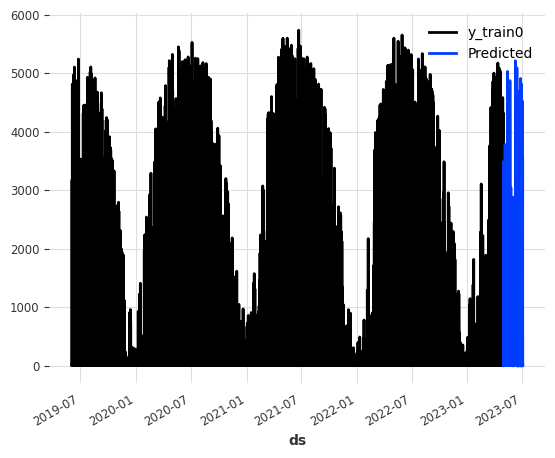

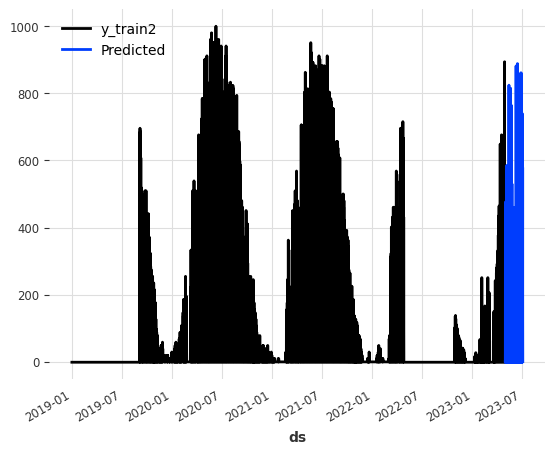

In [ ]:
predictions = []
all_predictions = []
for i in range(3):
    #yt = train_series[i].univariate_component("y")
    print(f"SHape of covariate_future: {covariate_future[i].pd_dataframe().shape}")
    print(covariate_future[i].start_time(), "\tEnd: ", covariate_future[i].end_time())
    print(f"SHape of train_series: {train_series[i].pd_dataframe().shape}", "should be one more column than covariate_future because of y")
    print(train_series[i].start_time(), "\tEnd: ", train_series[i].end_time())
    #print(covariate_trains_list[i].start_time(), "\tEnd: ", covariate_trains_list[i].end_time())


    if predict_multivariate:
        all_pred = models[i].predict(len(covariate_future[i]), series=train_series[i], future_covariates=covariate_trains_list[i].concatenate(covariate_future[i]))
        all_predictions.append(all_pred)
        y_pred = all_pred.univariate_component("y")
    else:
        y_pred = models[i].predict(len(covariate_future[i]), series=y_trains_list[i], future_covariates=covariate_trains_list[i].concatenate(covariate_future[i]))

    predictions.append(y_pred)

    # for j in range(len(y_trains)):
    #     y_trains[j].plot(label=f"y_train{j}")
    y_trains_list[i].plot(label=f"y_train{i}", new_plot=True)
    y_pred.plot(label='Predicted')

In [ ]:
for i in range(3):
    if predict_multivariate:
        for exog in EXOGENOUS:
            all_predictions[i].univariate_component(exog).plot(label=f"Predicted {exog}", new_plot=True)
            covariate_future[i].univariate_component(exog).plot(label=f"Actual {exog}")

### Submit

In [ ]:
# pull in test.csv and create submission.csv
test = pd.read_csv('test.csv', index_col=0)
# test has Id, Time, Location
# X_test has location_A, location_B, location_C
# we have to make sure that test has same dates as X_test, then predict y for each row in test, then save as submission.csv (using correct Id from test)

# convert index to datetime
test["id"] = test.index
test.set_index('time', inplace=True)
test.index = pd.to_datetime(test.index).astype('datetime64[ns]')
test

# split test into each location
print(test.groupby('location').count())


          prediction   id
location                 
A                720  720
B                720  720
C                720  720


A
component                     y
ds                             
2023-05-01 00:00:00    0.000001
2023-05-01 01:00:00   -0.005687
2023-05-01 02:00:00    0.242077
2023-05-01 03:00:00   35.415476
2023-05-01 04:00:00  258.029803
...                         ...
2023-07-03 19:00:00  127.171707
2023-07-03 20:00:00   43.156905
2023-07-03 21:00:00   -6.181147
2023-07-03 22:00:00   -0.086498
2023-07-03 23:00:00   -0.211067

[1536 rows x 1 columns]
B
component                    y
ds                            
2023-05-01 00:00:00   9.626049
2023-05-01 01:00:00   3.730669
2023-05-01 02:00:00   6.507932
2023-05-01 03:00:00   4.899353
2023-05-01 04:00:00  39.833765
...                        ...
2023-07-03 19:00:00  77.516650
2023-07-03 20:00:00  56.946812
2023-07-03 21:00:00  47.526920
2023-07-03 22:00:00  66.275355
2023-07-03 23:00:00  70.329301

[1536 rows x 1 columns]
C
component                    y
ds                            
2023-05-01 00:00:00   0.000024
2023-05-01 01:00:00   0.000038
2

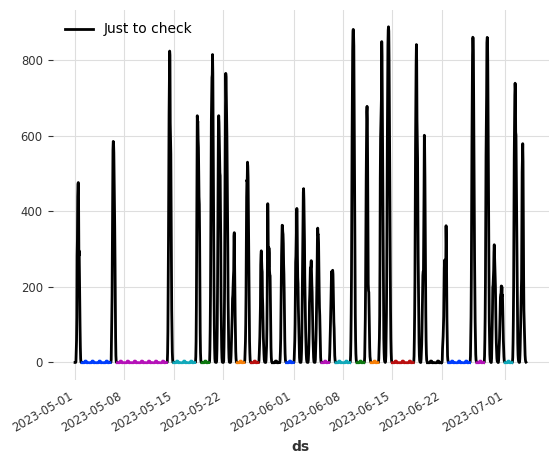

In [ ]:
import os
import pandas as pd

# Assuming X_test and model are already defined
# Assuming 'time' is also a datetime64[ns] column in X_test

location_mapping = {
    'A': 0,
    'B': 1,
    'C': 2
}

# Initialize an empty DataFrame to store the results
submission_df = pd.DataFrame()

# Group test by 'location' and iterate through each group
for location, group in test.groupby('location'):
    print(location)
    prediction = predictions[location_mapping[location]]
    y_pred = prediction.pd_dataframe()
    print(y_pred)
    
    # print(len(y_pred_submission), len(submission_series))
    # print(y_pred_submission.all_values().shape)
    #print(y_pred_submission.pd_dataframe()["y"])
    
    # Merge group and y_pred based on the index
    merged_df = pd.merge_asof(group.sort_index(), y_pred.sort_index(),
                              left_index=True, right_index=True)

    to_plot = TimeSeries.from_dataframe(df=merged_df[["y"]], freq="H", fill_missing_dates=False, fillna_value=None)
    to_plot.plot(label="Just to check", new_plot=True)

    all_gaps = to_plot.gaps()
    print_all_gaps = []
    for index, row in all_gaps.iterrows():
        gap_start, gap_end = row['gap_start'], row['gap_end']
        
        sliced_series = prediction.slice(gap_start, gap_end)
        print_all_gaps.append(sliced_series)
        sliced_series.plot(label=None)


    
    # Create a DataFrame with 'Id' and predicted values
    result_df = pd.DataFrame({
        'id': merged_df['id'],
        'prediction': merged_df['y']
    })
    
    # Append to submission DataFrame
    submission_df = pd.concat([submission_df, result_df])


# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv
# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}.csv'

# Save the submission
submission_df.to_csv(os.path.join('submissions', new_filename), index=False)


In [ ]:
def handle_not_serializable(obj):
    if hasattr(obj, '__dict__'):  # Check if obj has attributes
        return obj.__dict__
    else:
        raise TypeError(f"Object of type {type(obj).__name__} is not JSON serializable")

# get datetime
import datetime
import json
dt_now = datetime.datetime.now()

# Initialize an empty list to store all parameter dictionaries
all_params = []

for i in range(3):
    params = {**models[i].model_params}
    print(params)
    # pop "forecasting_models" from params
    models_params = params.pop("forecasting_models", None)
    print("models_params:", models_params)
    if models_params is not None:
        params["forecasting_models"] = [{"name": type(model).__name__, **model.model_params} for model in models_params]
    print(f"Best parameters for location {i}: ", params.items())
    
    # Append the current params dictionary to the all_params list
    all_params.append(params)

# Save the list of parameter dictionaries to a single JSON file
directory = f"models/{model_name}/submisison_{last_submission_number+1}"

# Create directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

with open(f"{directory}/best_params.json", "w") as outfile:
    json.dump(all_params, outfile, default=handle_not_serializable, indent=4)

# save model aswell
for i in range(3):
    models[i].save(f"{directory}/{type(models[i]).__name__}_{i}.pkl")


# save other params
other_params = {
    "EXOGENOUS": EXOGENOUS,
    "one_model_for_all": one_model_for_all,
    "is_single_gbtree_model": is_single_gbtree_model,
    "use_validation_set": use_validation_set,
    "train_val_split": train_val_split,
    "use_gridsearch": use_gridsearch,
    "forecast_horizon": forecast_horizon,
    "stride": stride,
    "start": start,
    "model_name": model_name,
    "use_naive_ensemble": use_naive_ensemble,
    "models_to_train": models_to_train,
    "fillna_value": fillna_value,
    "fillna_only_y": fillna_only_y,
    "use_all_even_with_missing": use_all_even_with_missing,
    "predict_multivariate": predict_multivariate,
}

with open(f"{directory}/variables.json", "w") as outfile:
    json.dump(other_params, outfile, default=handle_not_serializable, indent=4)
    

{'train_forecasting_models': False, 'show_warnings': True, 'forecasting_models': [XGBModel(lags=[-8760], lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, add_encoders={'datetime_attribute': {'future': ['hour', 'month']}}, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=500, max_depth=6, learning_rate=0.03, objective=reg:absoluteerror, booster=gbtree), CatBoostModel(lags=[-8760], lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, add_encoders={'datetime_attribute': {'future': ['hour', 'month']}}, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=500, max_depth=6, learning_rate=0.03, objective=MAE)]}
models_params: [XGBModel(lags=[-8760], lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=1, add_encoders={'datetime_attribute': {'future': ['hour', 'month']}}, likelihood=None, quantiles=None

## Autogluon

This is the approach from the second short notebook in the delivery and the last approach we tried. It gave a result of 142.8 on the public leaderboard. Throughout the project we have tried a lot of variations of using autogluon. For example, the first short notebook showcases a slightly different approach with no custom hyperparameter optimization and with only one seed. 

We really recommend listening to this podcast episode with the creator of autogluon Nick Erickson. It gives a lot of insight into the framework and how it can be used. https://open.spotify.com/episode/2FnO2rGgbj8Zzch6mlVVym?si=7d5c25aebd2049e3. We think this is awesome, altough it usually it is more performant on standard i.i.d. datasets, where the multi layer stacking can be used to its best potential.

In [ ]:
import os


# if submissions folder does not exist, create it
if not os.path.exists('submissions'):
    os.makedirs('submissions')

# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

print("New filename:", new_filename)

Last submission number: 141
Now creating submission number: 142
New filename: submission_142


In [ ]:
predictors = [None, None, None]

In [ ]:
def fit_predictor_for_location(loc):
    # All of these hyperparameters have been found by experimenting with some standard parameters in AutoGluon, and then only using the best ones for each location to make the train time shorter
    r118 = {'extra_trees': True, 'feature_fraction': 0.7832570544199176, 'learning_rate': 0.021720607471727896, 'min_data_in_leaf': 3, 'num_leaves': 21, 'ag_args': {'name_suffix': '_r118', 'priority': 17}}
    r51 = {'bs': 1024, 'emb_drop': 0.6046989241462619, 'epochs': 48, 'layers': [200, 100, 50], 'lr': 0.00775309042164966, 'ps': 0.09244767444160731, 'ag_args': {'name_suffix': '_r51', 'priority': 12}}
    r145 = {'bs': 128, 'emb_drop': 0.44339037504795686, 'epochs': 31, 'layers': [400, 200, 100], 'lr': 0.008615195908919904, 'ps': 0.19220253419114286, 'ag_args': {'name_suffix': '_r145', 'priority': 9}}
    lgbmXT = {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}
    if loc == "A":
        hyperparameters = {
            'NN_TORCH': {},
            'GBM': [lgbmXT, r118, 'GBMLarge'],#, r_118],
            'FASTAI': [r51],
        }
    elif loc == "B":
        hyperparameters = {
            'NN_TORCH': {},
            'GBM': [r118],
            'FASTAI': [{}, r145],
        }

    elif loc == "C":
        hyperparameters = {
            'NN_TORCH': {},
	        'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}],
            'GBM': [r118],
            'FASTAI': [r51],
        }


    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
    ).fit(
        train_data=train_data[train_data["location"] == loc].drop(columns=["ds"]),
        time_limit=time_limit, 
        presets=presets, 
        num_stack_levels=num_stack_levels,
        num_bag_folds=num_bag_folds,
        num_bag_sets=num_bag_sets,
        tuning_data=tuning_data[tuning_data["location"] == loc].reset_index(drop=True).drop(columns=["ds"]),
        hyperparameters = hyperparameters,
        use_bag_holdout=use_bag_holdout,
        #excluded_model_types=excluded_model_types
    )

    # evaluate on test data
    if use_test_data:
        t = test_data[test_data["location"] == loc]
        perf = predictor.evaluate(t)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=3
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_142_A/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.197-1 (2023-09-29)
Disk Space Avail:   141.94 GB / 315.93 GB (44.9%)
Train Data Rows:    30934
Train Data Columns: 44
Tuning Data Rows:    1485
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 673.41535, 1195.24)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', '

Evaluation on test data:
-105.74273165718836


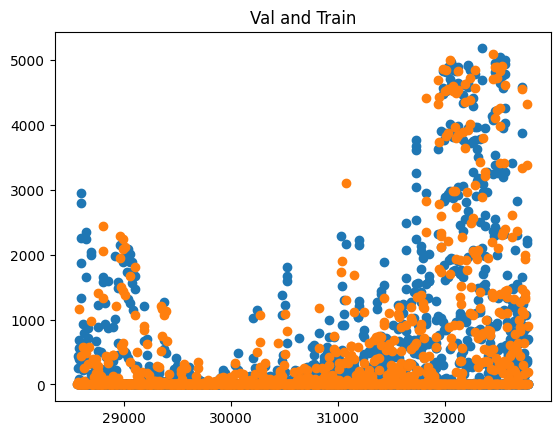

                        model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           LightGBMXT_BAG_L1 -105.629299 -86.171125        2.757117     267.977811   66.673744                 2.757117              267.977811          66.673744            1       True          1
1         WeightedEnsemble_L2 -105.742732 -82.247352       15.061079     835.773022  458.526718                 0.004030                0.000701           0.214789            2       True          6
2  NeuralNetFastAI_r51_BAG_L1 -106.247964 -95.666327        0.383407       0.937461   38.080469                 0.383407                0.937461          38.080469            1       True          4
3        LightGBM_r118_BAG_L1 -106.870624 -85.259916        2.342607     188.234109   51.846491                 2.342607              188.234109          51.846491            1       True          3
4    

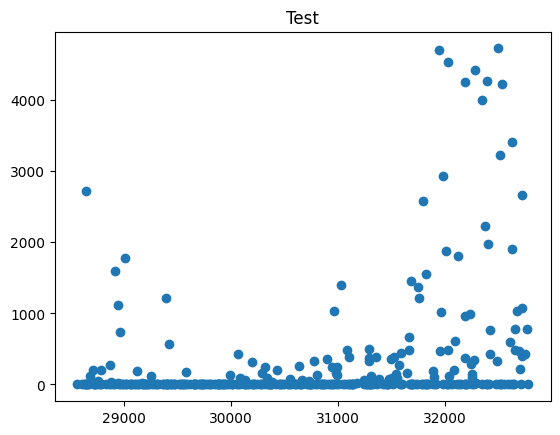

In [ ]:
import matplotlib.pyplot as plt
leaderboards = [None, None, None]
def leaderboard_for_location(i, loc):
    plt.scatter(train_data[(train_data["location"] == loc) & (train_data["is_estimated"]==True)]["y"].index, train_data[(train_data["location"] == loc) & (train_data["is_estimated"]==True)]["y"])
    plt.scatter(tuning_data[tuning_data["location"] == loc]["y"].index, tuning_data[tuning_data["location"] == loc]["y"])
    plt.title("Val and Train")
    plt.show()

    if use_test_data:
        lb = predictors[i].leaderboard(test_data[test_data["location"] == loc])
        lb["location"] = loc
        plt.scatter(test_data[test_data["location"] == loc]["y"].index, test_data[test_data["location"] == loc]["y"])
        plt.title("Test")
        
        return lb
    
    return pd.DataFrame()

leaderboards[0] = leaderboard_for_location(0, loc)

Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=3
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_142_B/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.197-1 (2023-09-29)
Disk Space Avail:   137.93 GB / 315.93 GB (43.7%)
Train Data Rows:    27377
Train Data Columns: 44
Tuning Data Rows:    1485
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 98.11625, 206.48535)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 

Evaluation on test data:
-10.7894783641021


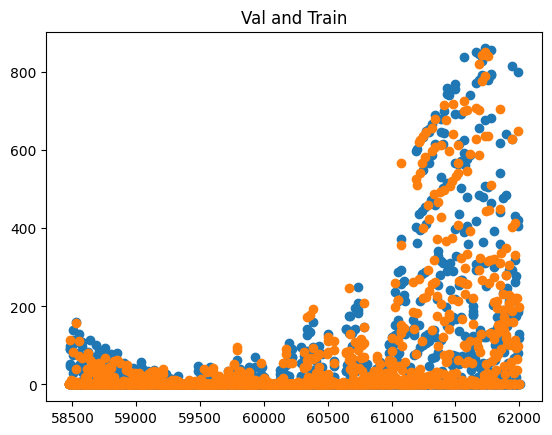

                         model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0          WeightedEnsemble_L2  -10.789478 -12.324207        4.397277     162.457627  361.852653                 0.003336                0.000642           0.168811            2       True          5
1         LightGBM_r118_BAG_L1  -11.008035 -12.921242        2.348640     156.671800   47.358682                 2.348640              156.671800          47.358682            1       True          3
2        NeuralNetTorch_BAG_L1  -11.182017 -12.836698        0.574365       1.147147  168.137105                 0.574365                1.147147         168.137105            1       True          2
3       NeuralNetFastAI_BAG_L1  -12.273773 -13.198685        0.498963       1.545790   44.273498                 0.498963                1.545790          44.273498            1       True          1


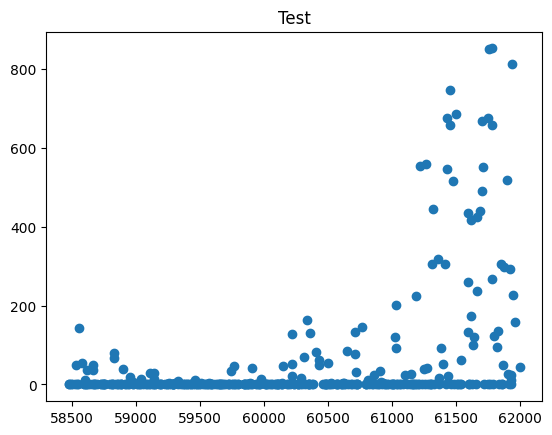

In [ ]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)
leaderboards[1] = leaderboard_for_location(1, loc)

Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=3
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_142_C/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.197-1 (2023-09-29)
Disk Space Avail:   137.39 GB / 315.93 GB (43.5%)
Train Data Rows:    24073
Train Data Columns: 44
Tuning Data Rows:    1481
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 80.87539, 169.67845)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclas

Evaluation on test data:
-11.875635142630587


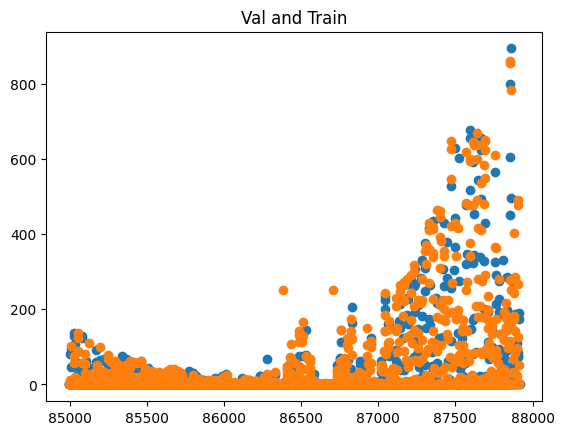

                        model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L2  -11.875635 -11.118753        3.301615     122.859288  196.134156                 0.003131                0.000628           0.173273            2       True          5
1        LightGBM_r118_BAG_L1  -11.977019 -11.213239        2.352773     120.538184   46.121330                 2.352773              120.538184          46.121330            1       True          3
2  NeuralNetFastAI_r51_BAG_L1  -12.945380 -12.489102        0.377565       0.844247   30.014023                 0.377565                0.844247          30.014023            1       True          4
3       NeuralNetTorch_BAG_L1  -13.236768 -13.391358        0.546498       1.076832  119.800254                 0.546498                1.076832         119.800254            1       True          2
4    

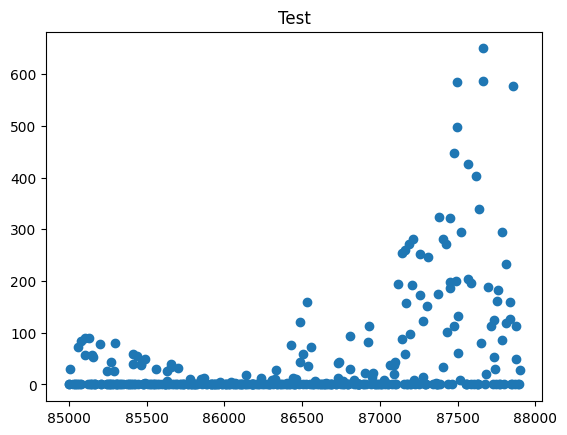

In [ ]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)
leaderboards[2] = leaderboard_for_location(2, loc)

In [ ]:
# save leaderboards to csv
pd.concat(leaderboards).to_csv(f"leaderboards/{new_filename}.csv")


for i in range(len(predictors)):
    print(f"Predictor {i}:")
    print(predictors[i].info()["model_info"]["WeightedEnsemble_L2"]["children_info"]["S1F1"]["model_weights"])

Predictor 0:
{'LightGBMXT_BAG_L1': 0.2823529411764706, 'NeuralNetTorch_BAG_L1': 0.35294117647058826, 'LightGBM_r118_BAG_L1': 0.16470588235294117, 'LightGBMLarge_BAG_L1': 0.2}
Predictor 1:
{'NeuralNetFastAI_BAG_L1': 0.14893617021276595, 'NeuralNetTorch_BAG_L1': 0.2872340425531915, 'LightGBM_r118_BAG_L1': 0.3829787234042553, 'NeuralNetFastAI_r145_BAG_L1': 0.18085106382978725}
Predictor 2:
{'KNeighborsUnif_BAG_L1': 0.036585365853658534, 'NeuralNetTorch_BAG_L1': 0.012195121951219513, 'LightGBM_r118_BAG_L1': 0.8170731707317073, 'NeuralNetFastAI_r51_BAG_L1': 0.13414634146341464}


### Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

future_test_data = TabularDataset('X_test_raw.csv')
future_test_data["ds"] = pd.to_datetime(future_test_data["ds"])

Loaded data from: X_test_raw.csv | Columns = 45 / 45 | Rows = 4608 -> 4608


In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
future_test_data_merged = pd.merge(future_test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in future_test_data.groupby('location'):
    i = location_map[loc]
    subset = future_test_data_merged[future_test_data_merged["location"] == loc].reset_index(drop=True)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    #tuning_data.loc[tuning_data["location"] == loc, "prediction"] =  predictors[i].predict(tuning_data[tuning_data["location"] == loc])
    if use_test_data:
        # get predictions for local test_data
        test_data.loc[test_data["location"] == loc, "prediction"] =  predictors[i].predict(test_data[test_data["location"] == loc])  

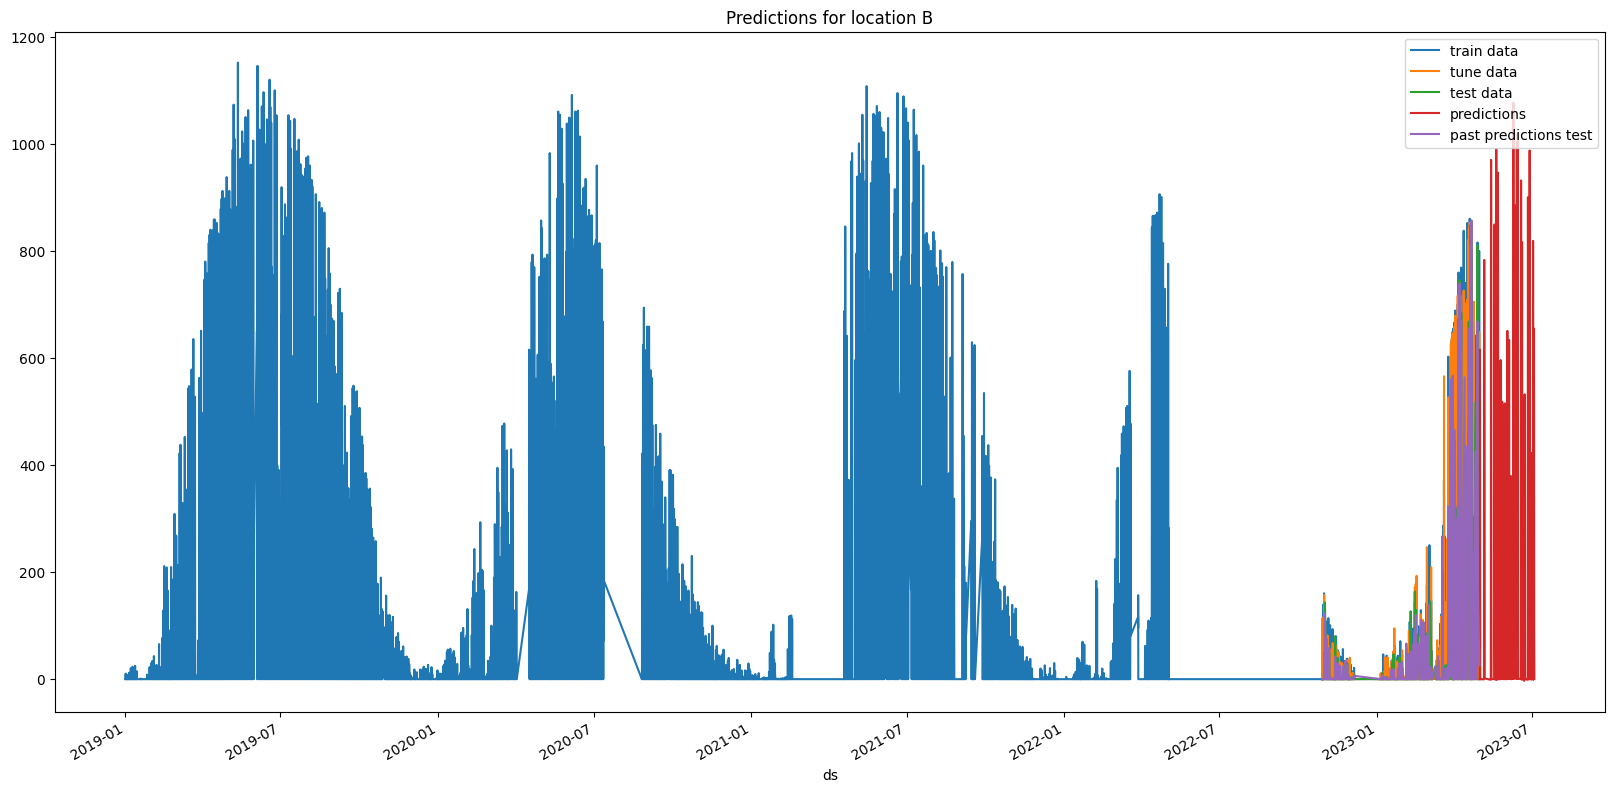

In [ ]:
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data[train_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")
    tuning_data[tuning_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="tune data")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="test data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    #tuning_data[tuning_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions tune")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions test")


    ax.set_title(f"Predictions for location {loc}")

In [ ]:
temp_predictions = [prediction.copy() for prediction in predictions]
if clip_predictions:
    # clip predictions smaller than 0 to 0
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())


# concatenate predictions
submissions_df = pd.concat(temp_predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

Smallest prediction: -30.471474
Smallest prediction after clipping: 0.0
Smallest prediction: -3.0752246
Smallest prediction after clipping: 0.0
Smallest prediction: -3.1478677
Smallest prediction after clipping: 0.0


id  prediction
0       0    0.000000
1       1    0.000000
2       2    0.000000
3       3   30.471388
4       4  309.942200
..    ...         ...
715  2155   62.359646
716  2156   35.705055
717  2157    8.107715
718  2158    1.970510
719  2159    1.575655

[2160 rows x 2 columns]

In [ ]:
# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_142.csv


### Feature Importance

It's interesting to see that instantaneous direct radiation, clear sky radiation and diffuse radiation (effect, Watts) are the most important features. We would have thought that the total energy over the last hour would be a better indicator of total PV power production over the hour than the mean of the effects of the radiation over an hour.

In [ ]:
# feature importance
print("\033[1m" + "Calculating feature importance for location A..." + "\033[0m")
print(predictors[0].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "A"], time_limit=60*10))
print("\033[1m" + "Calculating feature importance for location B..." + "\033[0m")
print(predictors[1].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "B"], time_limit=60*10))
print("\033[1m" + "Calculating feature importance for location C..." + "\033[0m")
print(predictors[2].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "C"], time_limit=60*10))

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'snow_drift:idx', 'location', 'prediction']
Computing feature importance via permutation shuffling for 41 features using 361 rows with 10 shuffle sets... Time limit: 600s...


Calculating feature importance for location A...


	6299.62s	= Expected runtime (629.96s per shuffle set)
	556.69s	= Actual runtime (Completed 8 of 10 shuffle sets) (Early stopping due to lack of time...)
These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'location', 'prediction']
Computing feature importance via permutation shuffling for 42 features using 361 rows with 10 shuffle sets... Time limit: 600s...


                                importance     stddev       p_value  n  \
direct_rad:W                    104.069145   5.795764  1.502413e-10  8   
clear_sky_rad:W                  68.575522  10.068412  1.265379e-07  8   
diffuse_rad:W                    62.134230   7.578349  3.516900e-08  8   
sun_elevation:d                  25.859155   5.634662  1.873632e-06  8   
sun_azimuth:d                    24.264215  10.749928  1.864269e-04  8   
clear_sky_energy_1h:J            18.317073   7.712776  1.365413e-04  8   
direct_rad_1h:J                  16.850952   3.857918  2.614651e-06  8   
effective_cloud_cover:p          12.321047   2.588230  1.462885e-06  8   
total_cloud_cover:p              12.293495   2.463435  1.062471e-06  8   
diffuse_rad_1h:J                  9.097221   3.379883  6.246524e-05  8   
relative_humidity_1000hPa:p       8.966096   2.066613  2.735902e-06  8   
snow_water:kgm2                   7.251352   3.935467  6.186022e-04  8   
ceiling_height_agl:m              5.72

	1866.73s	= Expected runtime (186.67s per shuffle set)
	338.5s	= Actual runtime (Completed 10 of 10 shuffle sets)
These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'snow_drift:idx', 'location', 'prediction']
Computing feature importance via permutation shuffling for 41 features using 360 rows with 10 shuffle sets... Time limit: 600s...


                                importance    stddev       p_value   n  \
clear_sky_rad:W                  31.587960  2.610076  1.409745e-11  10   
direct_rad:W                     19.005209  1.239041  1.686452e-12  10   
diffuse_rad:W                    14.643005  1.777099  4.356866e-10  10   
sun_elevation:d                  10.150755  1.139892  2.183115e-10  10   
clear_sky_energy_1h:J             7.924555  1.267501  5.025189e-09  10   
sun_azimuth:d                     7.634168  1.078358  1.675814e-09  10   
direct_rad_1h:J                   3.855799  0.595161  3.671306e-09  10   
effective_cloud_cover:p           3.348848  0.568381  8.473403e-09  10   
diffuse_rad_1h:J                  3.307861  0.845782  2.975928e-07  10   
fresh_snow_24h:cm                 2.204943  0.612355  6.011762e-07  10   
is_in_shadow:idx                  1.485250  0.173928  3.170873e-10  10   
relative_humidity_1000hPa:p       1.408372  0.381177  4.831119e-07  10   
cloud_base_agl:m                  1.38

	1469.61s	= Expected runtime (146.96s per shuffle set)
	167.27s	= Actual runtime (Completed 10 of 10 shuffle sets)


                                  importance    stddev       p_value   n  \
clear_sky_rad:W                 9.492532e+00  0.799178  1.666848e-11  10   
clear_sky_energy_1h:J           7.382851e+00  0.668056  3.177582e-11  10   
direct_rad:W                    5.329617e+00  0.649175  4.500538e-10  10   
direct_rad_1h:J                 3.410787e+00  0.449938  9.139202e-10  10   
sun_elevation:d                 3.150492e+00  0.428365  1.195200e-09  10   
sun_azimuth:d                   3.138013e+00  0.618942  3.159672e-08  10   
diffuse_rad:W                   2.284770e+00  0.412072  1.444585e-08  10   
diffuse_rad_1h:J                1.737366e+00  0.211993  4.571480e-10  10   
t_1000hPa:K                     1.443522e+00  0.944473  4.648883e-04  10   
air_density_2m:kgm3             1.236523e+00  0.564241  3.417133e-05  10   
effective_cloud_cover:p         1.085109e+00  0.249225  1.184326e-07  10   
is_day:idx                      1.073634e+00  0.118328  1.847534e-10  10   
fresh_snow_2